In [4]:
# Import and GPU Support
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import pickle

from B_data import *
from B_Plotting import Burgers_plot, loss_plot 

# Full PINN
from B_PINN1 import NN1
from B_PINN1_train import pinn1_train
#from B_PINN1_activation import P1
from B_PINN2_ind import NN2
from B_PINN2_train import pinn2_train

# Burgers GPT-PINN
from B_GPT_activation import P

torch.set_default_dtype(torch.float)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Current Device: {device}")
if torch.cuda.is_available():
    print(f"Current Device Name: {torch.cuda.get_device_name()}")

# Training Parameter Set
number_of_neurons = 2
nu1_training = np.linspace(1.0, 1.0, number_of_neurons)
nu2_training  = np.linspace(2.0, 2.0, number_of_neurons)

nu_training = []
for i in range(nu1_training.shape[0]):
    for j in range(nu2_training.shape[0]):
        nu_training.append([nu1_training[i],nu2_training[j]])
nu_training = np.array(nu_training)

nu_pinn_train = nu_training[0]
largest_loss_list = np.ones(number_of_neurons**2)
P_list = np.ones(number_of_neurons**2, dtype=object)
# Domain and Data
Xi, Xf         = -1.0, 1.5
Ti, Tf0         =  0.0, 0.1
Ti, Tf         =  0.0, 2/nu_pinn_train[1]
Ti2, Tf2       =  2/nu_pinn_train[1], 1.5

Nx_train0, Nt_train0 =  201, 101
Nx_train, Nt_train =  101, 201
Nx_test0, Nt_test0 =1001,11
Nx_test, Nt_test = 101, 201
IC_pts, IC_simple = 100, 100
BC_pts =  100
N_RH = IC_pts
dx = 0.001
dt = 0.0002

# Setting PINN and VGPT-PINN
layers_pinn = np.array([2, 30, 30, 30, 30, 30, 1])

lr_pinn0     = 0.001
epochs_pinn0 = 10000
tol_pinn0    = 5e-4

lr_pinn1     = 0.001
epochs_pinn1 = 20000
tol_pinn1    = 1e-4

lr_pinn2     = 0.0001
epochs_pinn2 = 25000
tol_pinn2   = 1e-4

lr_gpt          = 0.001
epochs_gpt      = 10000
tol_gpt         = 1e-3

pinn_train_times = np.ones(number_of_neurons)

Current Device: cuda
Current Device Name: NVIDIA A100-SXM4-40GB


******************************************************************
Epoch: 200 | loss: 0.8659317493438721,rMAE: 0.26396557688713074, rRMSE:0.2401745766401291,loss_RH:0.00000000,loss_con:4.02973032,loss_R:0.07576607167720795,loss_IC:0.07554469257593155,loss_BC:0.0034718727692961693
Epoch: 400 | loss: 0.8119394183158875,rMAE: 0.25298839807510376, rRMSE:0.23104719817638397,loss_RH:0.00000000,loss_con:4.04207659,loss_R:0.07055354118347168,loss_IC:0.072706438601017,loss_BC:0.001432148041203618
Epoch: 600 | loss: 0.7902499437332153,rMAE: 0.24988779425621033, rRMSE:0.22980517148971558,loss_RH:0.00000000,loss_con:4.06036663,loss_R:0.06987303495407104,loss_IC:0.07149455696344376,loss_BC:0.0005431314348243177
Epoch: 800 | loss: 0.7804868221282959,rMAE: 0.2485598772764206, rRMSE:0.23023895919322968,loss_RH:0.00000000,loss_con:4.06809759,loss_R:0.07007399946451187,loss_IC:0.07074806839227676,loss_BC:0.0002932064817287028
Epoch: 1000 | loss: 0.7742879390716553,rMAE: 0.247287780046463, rRMSE:0.230369

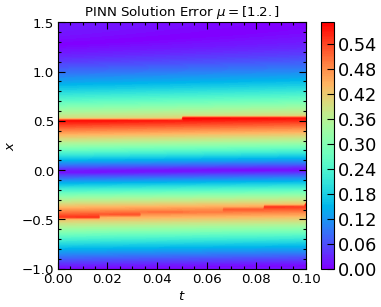

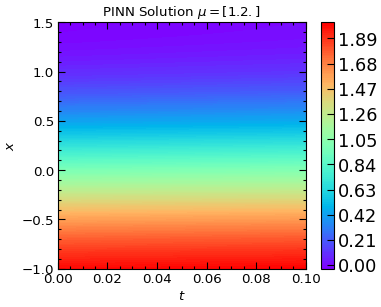

Epoch: 1200 | loss: 0.7694324254989624,rMAE: 0.24594372510910034, rRMSE:0.2301912158727646,loss_RH:0.00000000,loss_con:4.06210899,loss_R:0.06996124237775803,loss_IC:0.06977543979883194,loss_BC:0.00017167814075946808
Epoch: 1400 | loss: 0.7654696702957153,rMAE: 0.2449091225862503, rRMSE:0.22996248304843903,loss_RH:0.00000000,loss_con:4.05626106,loss_R:0.06979325413703918,loss_IC:0.06942062079906464,loss_BC:0.0001470234856242314
Epoch: 1600 | loss: 0.7620564699172974,rMAE: 0.24431923031806946, rRMSE:0.22978581488132477,loss_RH:0.00000000,loss_con:4.05172729,loss_R:0.06967749446630478,loss_IC:0.06909696757793427,loss_BC:0.0001409328542649746
Epoch: 1800 | loss: 0.7588039040565491,rMAE: 0.24396353960037231, rRMSE:0.2296028733253479,loss_RH:0.00000000,loss_con:4.04847622,loss_R:0.0695854052901268,loss_IC:0.06877385824918747,loss_BC:0.00014799050404690206
Epoch: 2000 | loss: 0.7551438808441162,rMAE: 0.24353310465812683, rRMSE:0.22932592034339905,loss_RH:0.00000000,loss_con:4.04616356,loss_R:

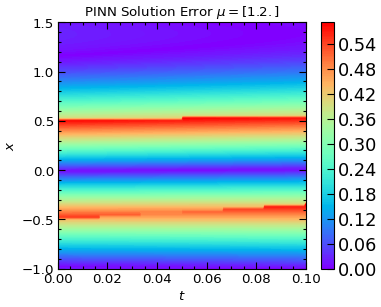

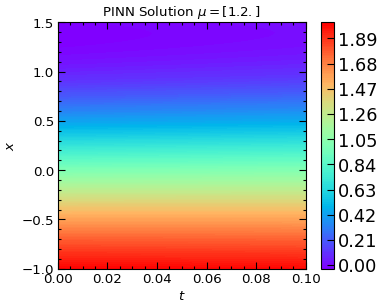

Epoch: 2200 | loss: 0.7546654343605042,rMAE: 0.24270713329315186, rRMSE:0.22879564762115479,loss_RH:0.00000000,loss_con:3.96061635,loss_R:0.06964906305074692,loss_IC:0.0681963637471199,loss_BC:0.0003052693500649184
Epoch: 2400 | loss: 0.74099200963974,rMAE: 0.24223417043685913, rRMSE:0.22847336530685425,loss_RH:0.00000000,loss_con:4.04302740,loss_R:0.06895152479410172,loss_IC:0.0670301616191864,loss_BC:0.0001738809805829078
Epoch: 2600 | loss: 0.7343139052391052,rMAE: 0.2411872148513794, rRMSE:0.22791458666324615,loss_RH:0.00000000,loss_con:4.23137522,loss_R:0.06832735240459442,loss_IC:0.06453220546245575,loss_BC:0.0020664504263550043
Epoch: 2800 | loss: 0.32820674777030945,rMAE: 0.14761874079704285, rRMSE:0.16785605251789093,loss_RH:0.00000000,loss_con:4.00733995,loss_R:0.03533073887228966,loss_IC:0.0291315708309412,loss_BC:0.0001560291275382042
Epoch: 3000 | loss: 0.23663480579853058,rMAE: 0.122441865503788, rRMSE:0.14336872100830078,loss_RH:0.00000000,loss_con:3.95258403,loss_R:0.02

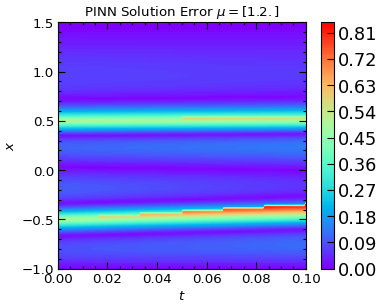

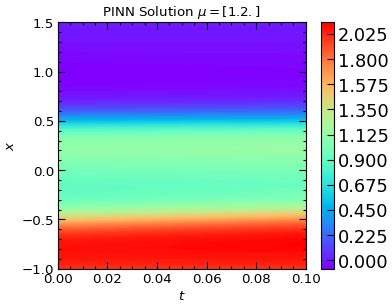

Epoch: 3200 | loss: 0.16424527764320374,rMAE: 0.08826889842748642, rRMSE:0.12404108047485352,loss_RH:0.00000000,loss_con:3.97162008,loss_R:0.018514523282647133,loss_IC:0.014529727399349213,loss_BC:4.334751793066971e-05
Epoch: 3400 | loss: 0.13605892658233643,rMAE: 0.08023762702941895, rRMSE:0.10918137431144714,loss_RH:0.00000000,loss_con:4.21605301,loss_R:0.013980567455291748,loss_IC:0.010752185247838497,loss_BC:0.0014556506648659706
Epoch: 3600 | loss: 0.09576362371444702,rMAE: 0.06197109818458557, rRMSE:0.09246722608804703,loss_RH:0.00000000,loss_con:3.84020996,loss_R:0.010068422183394432,loss_IC:0.007708802819252014,loss_BC:0.0008607169147580862
Epoch: 3800 | loss: 0.07208417356014252,rMAE: 0.053736474364995956, rRMSE:0.0789048820734024,loss_RH:0.00000000,loss_con:3.87642717,loss_R:0.007380197755992413,loss_IC:0.005956611596047878,loss_BC:0.0005137863918207586
Epoch: 4000 | loss: 0.051902707666158676,rMAE: 0.03893868997693062, rRMSE:0.06782186776399612,loss_RH:0.00000000,loss_con:3.

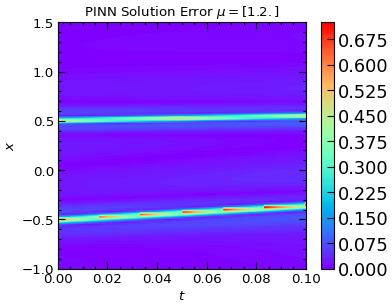

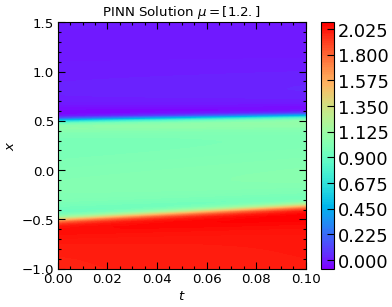

Epoch: 4200 | loss: 0.040737979114055634,rMAE: 0.032892871648073196, rRMSE:0.060938119888305664,loss_RH:0.00000000,loss_con:4.00166130,loss_R:0.0046195839531719685,loss_IC:0.0035818773321807384,loss_BC:2.996205512317829e-05
Epoch: 4400 | loss: 0.031432561576366425,rMAE: 0.02902272343635559, rRMSE:0.05568705126643181,loss_RH:0.00000000,loss_con:4.00135326,loss_R:0.003873061155900359,loss_IC:0.0027340538799762726,loss_BC:2.189627048210241e-05
Epoch: 4600 | loss: 0.030663510784506798,rMAE: 0.026951055973768234, rRMSE:0.05127882957458496,loss_RH:0.00000000,loss_con:3.86748958,loss_R:0.0034118853509426117,loss_IC:0.00215212837792933,loss_BC:0.0005730342818424106
Epoch: 4800 | loss: 0.017148029059171677,rMAE: 0.022762959823012352, rRMSE:0.04726334661245346,loss_RH:0.00000000,loss_con:3.99388933,loss_R:0.002822372131049633,loss_IC:0.0014210289809852839,loss_BC:1.1536617421370465e-05
Epoch: 5000 | loss: 0.012260377407073975,rMAE: 0.020748790353536606, rRMSE:0.04443654045462608,loss_RH:0.000000

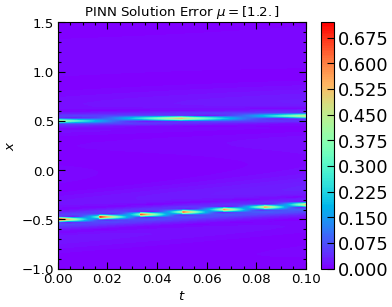

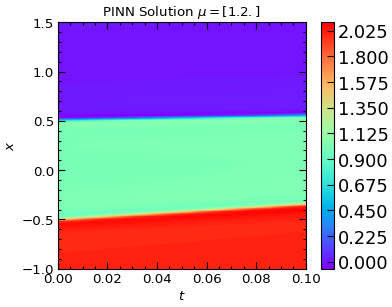

Epoch: 5200 | loss: 0.008794545195996761,rMAE: 0.01936231553554535, rRMSE:0.042142532765865326,loss_RH:0.00000000,loss_con:3.99807143,loss_R:0.0022322393488138914,loss_IC:0.0006502686883322895,loss_BC:5.961907845630776e-06
Epoch: 5400 | loss: 0.006457028444856405,rMAE: 0.01832086779177189, rRMSE:0.04057443514466286,loss_RH:0.00000000,loss_con:3.99951077,loss_R:0.002045779023319483,loss_IC:0.00043664051918312907,loss_BC:4.484438250074163e-06
Epoch: 5600 | loss: 0.005091385915875435,rMAE: 0.01812613010406494, rRMSE:0.03950230032205582,loss_RH:0.00000000,loss_con:4.01814508,loss_R:0.001910126069560647,loss_IC:0.00030393520137295127,loss_BC:1.4190772162692156e-05
Epoch: 5800 | loss: 0.003910847939550877,rMAE: 0.01650775596499443, rRMSE:0.0383499339222908,loss_RH:0.00000000,loss_con:3.99772954,loss_R:0.0017822793452069163,loss_IC:0.0002103217993862927,loss_BC:2.535063913455815e-06
Epoch: 6000 | loss: 0.003241200465708971,rMAE: 0.01570727862417698, rRMSE:0.037481021136045456,loss_RH:0.000000

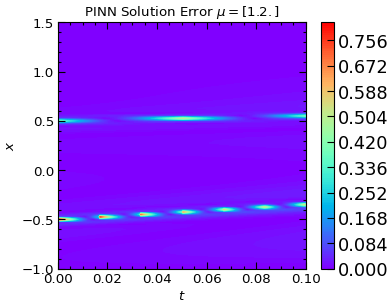

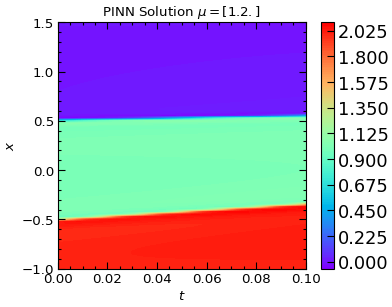

Epoch: 6200 | loss: 0.0027790251187980175,rMAE: 0.014938081614673138, rRMSE:0.03678031638264656,loss_RH:0.00000000,loss_con:3.99888039,loss_R:0.0016156173078343272,loss_IC:0.00011524344881763682,loss_BC:1.0973213875331567e-06
Epoch: 6400 | loss: 0.005838264245539904,rMAE: 0.02043948881328106, rRMSE:0.03748993203043938,loss_RH:0.00000000,loss_con:4.09007072,loss_R:0.0016586751444265246,loss_IC:0.00016560338553972542,loss_BC:0.00025235553039237857
Epoch: 6600 | loss: 0.0021865065209567547,rMAE: 0.01336453016847372, rRMSE:0.03554065525531769,loss_RH:0.00000000,loss_con:3.99844432,loss_R:0.0014928443124517798,loss_IC:6.890448275953531e-05,loss_BC:4.6173826717677e-07
Epoch: 6800 | loss: 0.0020027668215334415,rMAE: 0.012665322050452232, rRMSE:0.03495408222079277,loss_RH:0.00000000,loss_con:3.99834466,loss_R:0.0014494495699182153,loss_IC:5.497073652804829e-05,loss_BC:3.609756049627322e-07
Epoch: 7000 | loss: 0.002181188203394413,rMAE: 0.012607606127858162, rRMSE:0.034494489431381226,loss_RH:0

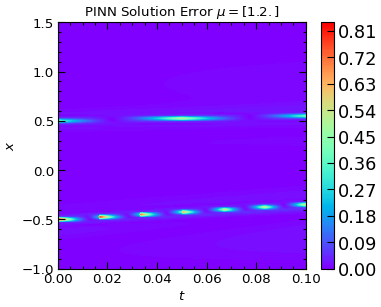

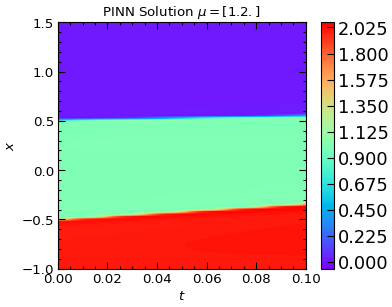

Epoch: 7200 | loss: 0.0017901911633089185,rMAE: 0.011690214276313782, rRMSE:0.03396792709827423,loss_RH:0.00000000,loss_con:3.98531938,loss_R:0.001360320602543652,loss_IC:3.6015157093061134e-05,loss_BC:6.971902166696964e-06
Epoch: 7400 | loss: 0.0016148706199601293,rMAE: 0.01073990948498249, rRMSE:0.03344688564538956,loss_RH:0.00000000,loss_con:3.99891520,loss_R:0.0013248180039227009,loss_IC:2.8817894417443313e-05,loss_BC:1.873625308235205e-07
Epoch: 7600 | loss: 0.0015369433676823974,rMAE: 0.010217440314590931, rRMSE:0.032925039529800415,loss_RH:0.00000000,loss_con:3.99596739,loss_R:0.0012929923832416534,loss_IC:2.373656207055319e-05,loss_BC:6.585320306840003e-07
Epoch: 7800 | loss: 0.006341584958136082,rMAE: 0.010034080594778061, rRMSE:0.03251812234520912,loss_RH:0.00000000,loss_con:4.10957766,loss_R:0.001384154544211924,loss_IC:0.00012462511949706823,loss_BC:0.00037111795973032713
Epoch: 8000 | loss: 0.0013884255895391107,rMAE: 0.009299310855567455, rRMSE:0.03200579434633255,loss_RH

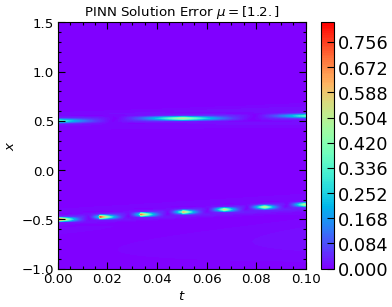

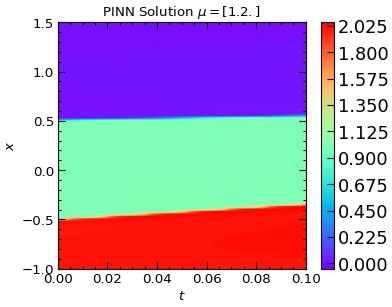

Epoch: 8200 | loss: 0.0013361298479139805,rMAE: 0.008964352309703827, rRMSE:0.031509388238191605,loss_RH:0.00000000,loss_con:3.99794126,loss_R:0.0011992030777037144,loss_IC:1.3432740161078982e-05,loss_BC:2.5993102781285415e-07
Epoch: 8400 | loss: 0.007495525758713484,rMAE: 0.01597081683576107, rRMSE:0.032524749636650085,loss_RH:0.00000000,loss_con:4.12307930,loss_R:0.001321368501521647,loss_IC:0.00014950719196349382,loss_BC:0.0004679085686802864
Epoch: 8600 | loss: 0.0012452033115550876,rMAE: 0.008379167877137661, rRMSE:0.030539780855178833,loss_RH:0.00000000,loss_con:3.99928951,loss_R:0.0011489765020087361,loss_IC:9.493317520536948e-06,loss_BC:1.2936570215060783e-07
Epoch: 8800 | loss: 0.0012042816961184144,rMAE: 0.00814136490225792, rRMSE:0.03004518896341324,loss_RH:0.00000000,loss_con:3.99944544,loss_R:0.0011208454379811883,loss_IC:8.230269486375619e-06,loss_BC:1.1335944094525985e-07
Epoch: 9000 | loss: 0.0011856760829687119,rMAE: 0.008014609105885029, rRMSE:0.029745250940322876,los

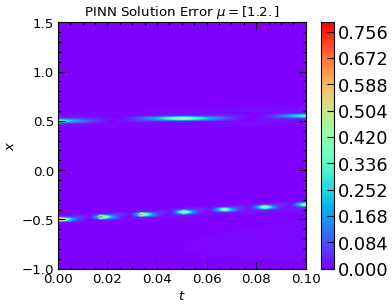

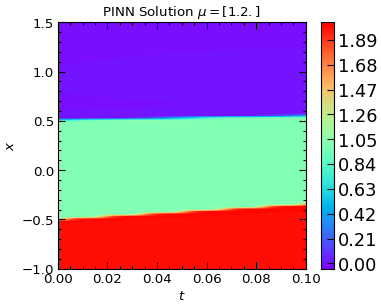

Epoch: 9200 | loss: 0.0011276841396465898,rMAE: 0.007685047574341297, rRMSE:0.029168087989091873,loss_RH:0.00000000,loss_con:3.99938011,loss_R:0.0010660334955900908,loss_IC:6.063792625354836e-06,loss_BC:1.0127577354523964e-07
Epoch: 9400 | loss: 0.0011004373664036393,rMAE: 0.007470631971955299, rRMSE:0.028657428920269012,loss_RH:0.00000000,loss_con:3.99965239,loss_R:0.0010433242423459888,loss_IC:5.629231964121573e-06,loss_BC:8.208169788304076e-08
Epoch: 9600 | loss: 0.001069631427526474,rMAE: 0.007297602482140064, rRMSE:0.02823515422642231,loss_RH:0.00000000,loss_con:3.99755239,loss_R:0.0010170722380280495,loss_IC:4.997176347387722e-06,loss_BC:2.5874206244225206e-07
Epoch: 9800 | loss: 0.002272871322929859,rMAE: 0.0073000360280275345, rRMSE:0.027764372527599335,loss_RH:0.00000000,loss_con:3.94459248,loss_R:0.0010195695795118809,loss_IC:2.6498781153350137e-05,loss_BC:9.883141319733113e-05
Epoch: 10000 | loss: 0.0010162016842514277,rMAE: 0.006873228121548891, rRMSE:0.027256028726696968,l

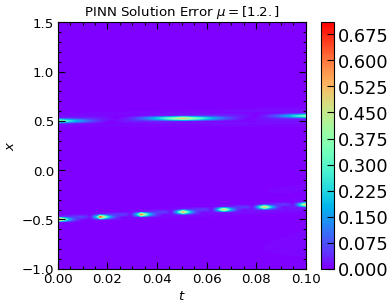

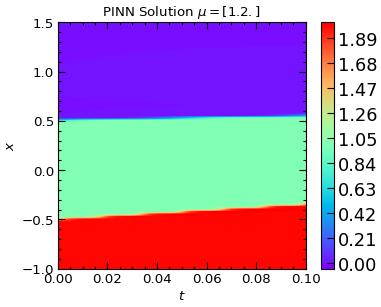

PINN Training Completed

PINN Training Time: 0.2127880855899356 Hours


In [7]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data0 = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test, Nt_test, dx,dt)
xt_resid0      = residual_data0[0].to(device)
f_hat0         = residual_data0[1].to(device)
xt_test0       = residual_data0[2].to(device)
xt_RHL0      = residual_data0[3].to(device)
xt_RHR0      = residual_data0[4].to(device)
xt_RHt0         = residual_data0[5].to(device)
xt_RHtL0       = residual_data0[6].to(device)

BC_data = create_BC_data(Xi, Xf, Ti, Tf0, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data0 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf0, IC_pts, IC_simple)
IC_xt0     = IC_data0[0].to(device)
IC_u0      = IC_data0[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt0, Tf0).to(device)

Exact_y0 = exact_u(nu_pinn_train,xt_test0)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

PINN0 = NN1(nu_pinn_train, layers_pinn,dt).to(device)
    
pinn1_losses = pinn1_train(PINN0, nu_pinn_train, xt_resid0, IC_xt0, IC_u0, BC1, BC2, xt_RHL0,xt_RHR0,xt_RHt0,xt_RHtL0, f_hat0, Exact_y0, epochs_pinn0, lr_pinn0, tol_pinn0, xt_test0)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")


In [8]:
Nx_test0=1001
Nt_test0=2
xt_test0 = create_residual_data(Xi, Xf, Ti, Tf0, Nx_train0, Nt_train0, Nx_test0, Nt_test0, dx,dt)[2].to(device)

tensor(0.0050, device='cuda:0') 0.10050251334905624 1.0


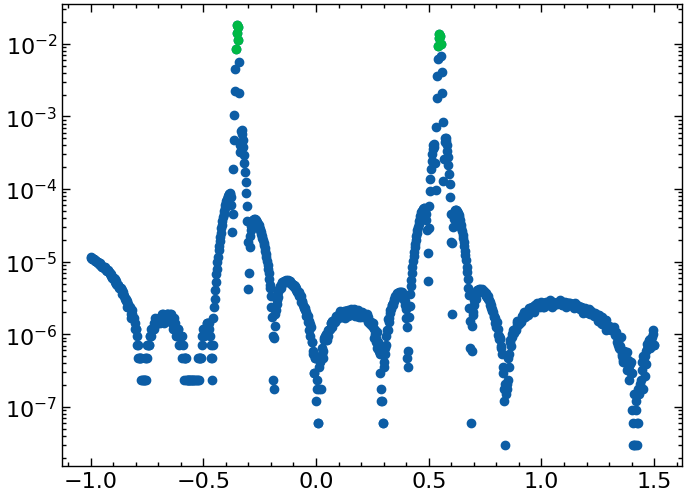

In [9]:
dx=1e-4
cut_x = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1), Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
cut_dx1 = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1)+dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
cut_dx2 = torch.cat([xt_test0[:Nx_test0, 0].unsqueeze(1)-dx, Tf0 * torch.ones(Nx_test0, 1).to(device)], dim=1)
diff_x=torch.abs(PINN0(cut_dx2)-PINN0(cut_dx1))
plt.scatter(cut_x[:Nx_test0,0].detach().cpu(),diff_x.detach().cpu())
top_values, top_indices = torch.topk(diff_x.squeeze(), k=10)
plt.scatter(cut_x[top_indices,0].detach().cpu(),diff_x[top_indices].detach().cpu())
cut_dx=torch.abs(cut_x[top_indices[-1],0]-cut_x[top_indices[0],0])
cut_t = (Tf0/(1-cut_dx)).item()
print(cut_dx,cut_t,2/nu_pinn_train[1])
plt.yscale('log')

In [10]:
y=diff_x.squeeze()
# Step 1: 找到所有局部极大值的索引
grad = torch.diff(y)  # 一阶差分来获取梯度
local_maxima = (grad[:-1] > 0) & (grad[1:] < 0)  # 局部极大值条件
peak_indices = torch.nonzero(local_maxima)[:, 0] + 1  # 局部极大值索引加 1 来对齐原数组

# Step 2: 找到两个峰值区域，挑选每个峰值区域的最高点
# 将极大值分为两组，按索引划分，假设两峰在不同区域
# （如果位置未知，也可以使用聚类算法对这些峰值进行分组）

# 例如假设前半段和后半段各有一个峰
first_peak_region = peak_indices[peak_indices < len(y) // 2]
second_peak_region = peak_indices[peak_indices >= len(y) // 2]

# Step 3: 获取每个区域的最大值索引
first_peak_index = first_peak_region[y[first_peak_region].argmax()]
second_peak_index = second_peak_region[y[second_peak_region].argmax()]

print("第一个峰的最高值索引:", first_peak_index.item())
print("第二个峰的最高值索引:", second_peak_index.item())

cut_dx=torch.abs(cut_x[second_peak_index,0]-cut_x[first_peak_index,0])
cut_t = (Tf0/(1-cut_dx)).item()
print(cut_dx,cut_t,2/nu_pinn_train[1])

第一个峰的最高值索引: 260
第二个峰的最高值索引: 619
tensor(0.8975, device='cuda:0') 0.9756101965904236 1.0


In [11]:
Ti, Tf         =  0.0, cut_t
Ti2, Tf2       =  cut_t, 1.5

******************************************************************
Epoch: 200 | loss: 0.9291262626647949,rMAE: 0.3053274154663086, rRMSE:0.34297728538513184,loss_RH:0.00000000,loss_con:4.05196095,loss_R:0.12723584473133087,loss_IC:0.07625534385442734,loss_BC:0.003933697007596493
Epoch: 400 | loss: 0.8621984720230103,rMAE: 0.2831837832927704, rRMSE:0.3198504149913788,loss_RH:0.00000000,loss_con:4.06371212,loss_R:0.11476388573646545,loss_IC:0.07337123155593872,loss_BC:0.0013722262810915709
Epoch: 600 | loss: 0.8328667283058167,rMAE: 0.24546803534030914, rRMSE:0.2744751572608948,loss_RH:0.00000000,loss_con:4.06965971,loss_R:0.0952492356300354,loss_IC:0.07246245443820953,loss_BC:0.0012992933625355363
Epoch: 800 | loss: 0.8192951679229736,rMAE: 0.22539685666561127, rRMSE:0.2523770332336426,loss_RH:0.00000000,loss_con:4.07416916,loss_R:0.08554646372795105,loss_IC:0.07199431955814362,loss_BC:0.0013805471826344728
Epoch: 1000 | loss: 0.8034567832946777,rMAE: 0.20741279423236847, rRMSE:0.234896

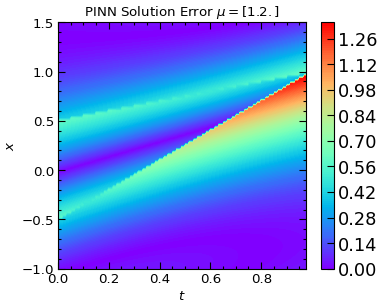

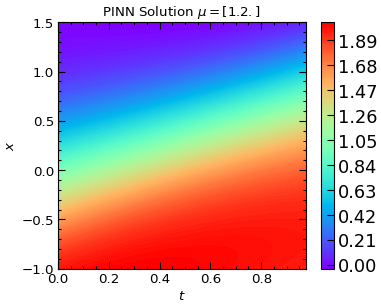

Epoch: 1200 | loss: 0.7636174559593201,rMAE: 0.18174433708190918, rRMSE:0.21010078489780426,loss_RH:0.00000000,loss_con:4.06397343,loss_R:0.06589790433645248,loss_IC:0.06878460198640823,loss_BC:0.000987357459962368
Epoch: 1400 | loss: 0.554995059967041,rMAE: 0.14216400682926178, rRMSE:0.15770076215267181,loss_RH:0.00000000,loss_con:4.02685261,loss_R:0.04587612673640251,loss_IC:0.050370633602142334,loss_BC:0.0005412536556832492
Epoch: 1600 | loss: 0.29968684911727905,rMAE: 0.12124869972467422, rRMSE:0.13021041452884674,loss_RH:0.00000000,loss_con:3.97677183,loss_R:0.03601633012294769,loss_IC:0.026274671778082848,loss_BC:9.237836638931185e-05
Epoch: 1800 | loss: 0.25516968965530396,rMAE: 0.0971667468547821, rRMSE:0.1130639836192131,loss_RH:0.00000000,loss_con:3.96759748,loss_R:0.02725336328148842,loss_IC:0.022615257650613785,loss_BC:0.0001763744803611189
Epoch: 2000 | loss: 0.20705820620059967,rMAE: 0.07877656817436218, rRMSE:0.10318487882614136,loss_RH:0.00000000,loss_con:3.97065711,los

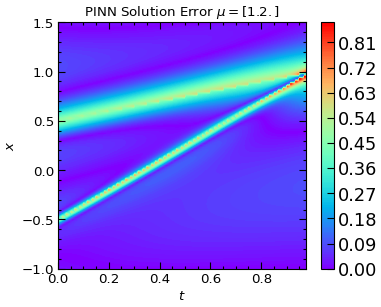

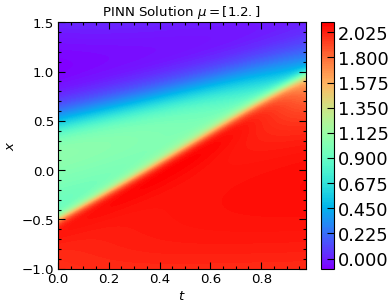

Epoch: 2200 | loss: 0.15882503986358643,rMAE: 0.06543048471212387, rRMSE:0.09347537904977798,loss_RH:0.00000000,loss_con:3.97472858,loss_R:0.016799457371234894,loss_IC:0.014041186310350895,loss_BC:0.0001613731583347544
Epoch: 2400 | loss: 0.11498762667179108,rMAE: 0.05064224824309349, rRMSE:0.07986630499362946,loss_RH:0.00000000,loss_con:3.97922969,loss_R:0.012288747355341911,loss_IC:0.010172819718718529,loss_BC:9.706809214549139e-05
Epoch: 2600 | loss: 0.07330907136201859,rMAE: 0.0354759506881237, rRMSE:0.06615857779979706,loss_RH:0.00000000,loss_con:3.98692632,loss_R:0.00800258107483387,loss_IC:0.006470261607319117,loss_BC:6.03877633693628e-05
Epoch: 2800 | loss: 0.05153895914554596,rMAE: 0.028934160247445107, rRMSE:0.05967621132731438,loss_RH:0.00000000,loss_con:4.02181435,loss_R:0.005938252899795771,loss_IC:0.004517358262091875,loss_BC:4.271213765605353e-05
Epoch: 3000 | loss: 0.039276041090488434,rMAE: 0.0259486585855484, rRMSE:0.055998168885707855,loss_RH:0.00000000,loss_con:4.00

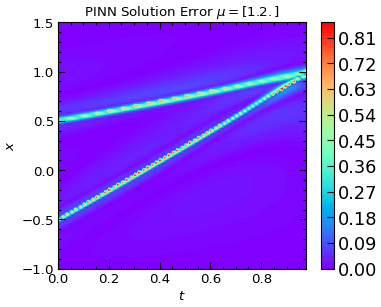

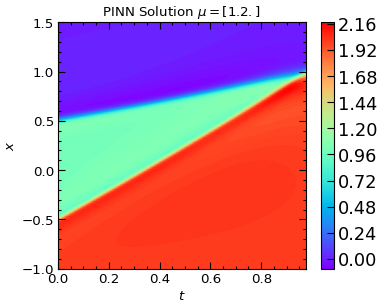

Epoch: 3200 | loss: 0.029818203300237656,rMAE: 0.023140257224440575, rRMSE:0.052720628678798676,loss_RH:0.00000000,loss_con:4.00451040,loss_R:0.0040647899731993675,loss_IC:0.0025619021616876125,loss_BC:1.3439321264741011e-05
Epoch: 3400 | loss: 0.022823581472039223,rMAE: 0.02291225455701351, rRMSE:0.04976298287510872,loss_RH:0.00000000,loss_con:3.95670700,loss_R:0.0034108965191990137,loss_IC:0.0018737949430942535,loss_BC:6.747354927938432e-05
Epoch: 3600 | loss: 0.01686318777501583,rMAE: 0.01950404793024063, rRMSE:0.04723440110683441,loss_RH:0.00000000,loss_con:3.94758344,loss_R:0.0029225859325379133,loss_IC:0.0013027654495090246,loss_BC:9.12948016775772e-05
Epoch: 3800 | loss: 0.014818403869867325,rMAE: 0.017679445445537567, rRMSE:0.04519510269165039,loss_RH:0.00000000,loss_con:3.90100932,loss_R:0.00257131434045732,loss_IC:0.0009089476661756635,loss_BC:0.00031576136825606227
Epoch: 4000 | loss: 0.007662861607968807,rMAE: 0.015011471696197987, rRMSE:0.043503161519765854,loss_RH:0.00000

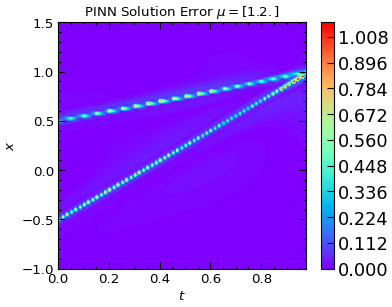

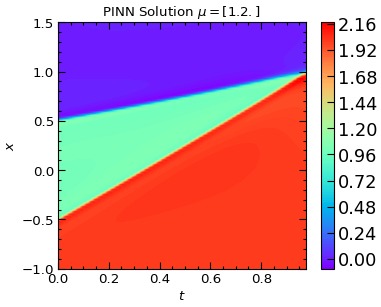

Epoch: 4200 | loss: 0.005510048940777779,rMAE: 0.013865772634744644, rRMSE:0.0423390232026577,loss_RH:0.00000000,loss_con:3.99758434,loss_R:0.002047240035608411,loss_IC:0.0003438475541770458,loss_BC:2.433318968542153e-06
Epoch: 4400 | loss: 0.004160233307629824,rMAE: 0.01301670167595148, rRMSE:0.041067443788051605,loss_RH:0.00000000,loss_con:3.99737930,loss_R:0.0018853882793337107,loss_IC:0.00022470262774731964,loss_BC:2.781869625323452e-06
Epoch: 4600 | loss: 0.0033097751438617706,rMAE: 0.012263204902410507, rRMSE:0.03899286687374115,loss_RH:0.00000000,loss_con:3.99851346,loss_R:0.001756425597704947,loss_IC:0.00015258693019859493,loss_BC:2.7480175504024373e-06
Epoch: 4800 | loss: 0.002848684787750244,rMAE: 0.011821496300399303, rRMSE:0.03814670816063881,loss_RH:0.00000000,loss_con:3.98341846,loss_R:0.0016668591415509582,loss_IC:0.00010706895409384742,loss_BC:1.1113623259007e-05
Epoch: 5000 | loss: 0.008437596261501312,rMAE: 0.01728847809135914, rRMSE:0.03835395351052284,loss_RH:0.0000

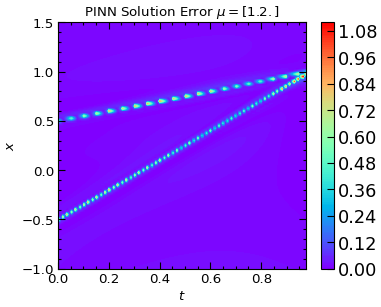

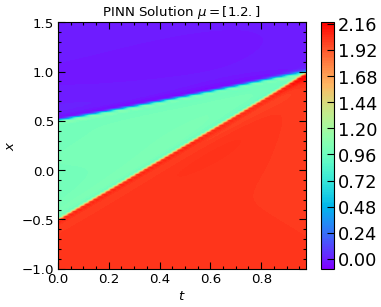

Epoch: 5200 | loss: 0.0021288893185555935,rMAE: 0.01082257367670536, rRMSE:0.036833811551332474,loss_RH:0.00000000,loss_con:3.99840808,loss_R:0.0015303919790312648,loss_IC:5.710034383810125e-05,loss_BC:2.7493822472024476e-06
Epoch: 5400 | loss: 0.0019545569084584713,rMAE: 0.010423985309898853, rRMSE:0.036260515451431274,loss_RH:0.00000000,loss_con:3.99898863,loss_R:0.0014962771674618125,loss_IC:4.33314053225331e-05,loss_BC:2.4965631837403635e-06
Epoch: 5600 | loss: 0.0018011750653386116,rMAE: 0.009992685168981552, rRMSE:0.035230882465839386,loss_RH:0.00000000,loss_con:3.99897194,loss_R:0.0014450021553784609,loss_IC:3.3335076295770705e-05,loss_BC:2.2822132450528443e-06
Epoch: 5800 | loss: 0.0016799136064946651,rMAE: 0.009674759581685066, rRMSE:0.03437715396285057,loss_RH:0.00000000,loss_con:3.99985933,loss_R:0.0013996097259223461,loss_IC:2.6133038772968575e-05,loss_BC:1.8973476016981294e-06
Epoch: 6000 | loss: 0.0015874631935730577,rMAE: 0.009223849512636662, rRMSE:0.03383328765630722,l

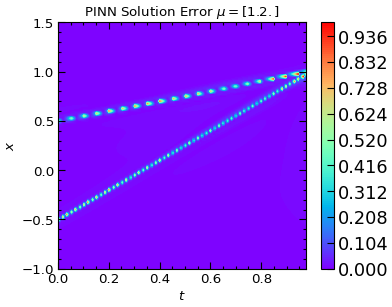

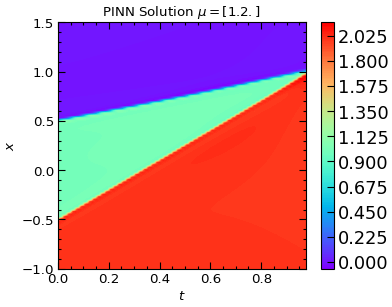

Epoch: 6200 | loss: 0.001515091978944838,rMAE: 0.008965328335762024, rRMSE:0.033405907452106476,loss_RH:0.00000000,loss_con:3.99969959,loss_R:0.00133149279281497,loss_IC:1.6741219951654784e-05,loss_BC:1.6186976381504792e-06
Epoch: 6400 | loss: 0.0014575389213860035,rMAE: 0.008686048910021782, rRMSE:0.03282127529382706,loss_RH:0.00000000,loss_con:4.00150490,loss_R:0.0013025429798290133,loss_IC:1.4066090443520807e-05,loss_BC:1.4335090554595808e-06
Epoch: 6600 | loss: 0.001988566480576992,rMAE: 0.010552491992712021, rRMSE:0.03290947154164314,loss_RH:0.00000000,loss_con:4.03796864,loss_R:0.001283871941268444,loss_IC:2.3318030798691325e-05,loss_BC:4.715143222711049e-05
Epoch: 6800 | loss: 0.0013570162700489163,rMAE: 0.00808875635266304, rRMSE:0.03222263604402542,loss_RH:0.00000000,loss_con:4.00006294,loss_R:0.0012448268244042993,loss_IC:1.0120945262315217e-05,loss_BC:1.0979988473991398e-06
Epoch: 7000 | loss: 0.0013191095786169171,rMAE: 0.007881776429712772, rRMSE:0.031997401267290115,loss_

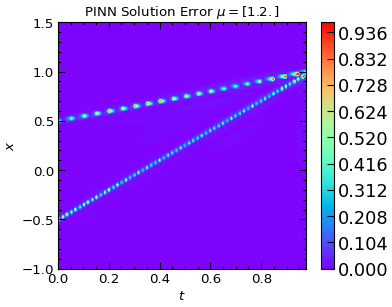

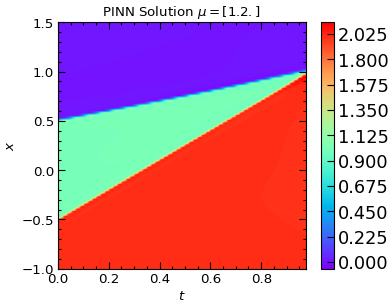

Epoch: 7200 | loss: 0.0012889367062598467,rMAE: 0.00772449653595686, rRMSE:0.031804170459508896,loss_RH:0.00000000,loss_con:4.00231028,loss_R:0.0012020030990242958,loss_IC:7.812380317773204e-06,loss_BC:8.809793143882416e-07
Epoch: 7400 | loss: 0.003195452969521284,rMAE: 0.007428128272294998, rRMSE:0.031573209911584854,loss_RH:0.00000000,loss_con:3.93082166,loss_R:0.0012523195473477244,loss_IC:3.915718843927607e-05,loss_BC:0.00015515615814365447
Epoch: 7600 | loss: 0.001227842178195715,rMAE: 0.007209911476820707, rRMSE:0.03150636702775955,loss_RH:0.00000000,loss_con:4.00028229,loss_R:0.0011582443257793784,loss_IC:6.39153904558043e-06,loss_BC:5.682498454007145e-07
Epoch: 7800 | loss: 0.001197034027427435,rMAE: 0.007069410756230354, rRMSE:0.03147256001830101,loss_RH:0.00000000,loss_con:4.00031376,loss_R:0.0011349946726113558,loss_IC:5.7466436373943e-06,loss_BC:4.5729257180937566e-07
Epoch: 8000 | loss: 0.0011751119745895267,rMAE: 0.006910362280905247, rRMSE:0.031231937929987907,loss_RH:0.

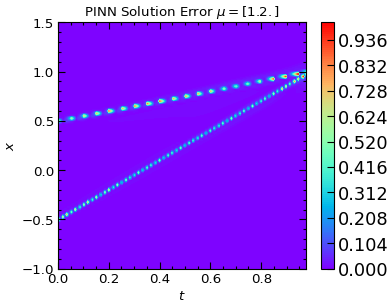

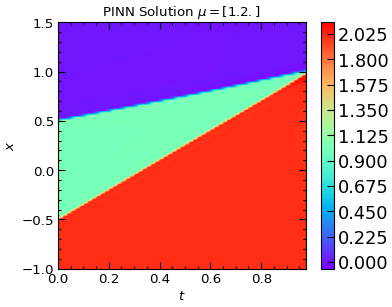

Epoch: 8200 | loss: 0.00313614122569561,rMAE: 0.008610209450125694, rRMSE:0.03105219267308712,loss_RH:0.00000000,loss_con:4.07086468,loss_R:0.0011349143460392952,loss_IC:4.408260792843066e-05,loss_BC:0.00015604007057845592
Epoch: 8400 | loss: 0.0011985304299741983,rMAE: 0.006398397963494062, rRMSE:0.030884940177202225,loss_RH:0.00000000,loss_con:3.99187970,loss_R:0.0010705392342060804,loss_IC:7.218679911602521e-06,loss_BC:5.580433025897946e-06
Epoch: 8600 | loss: 0.0011641565943136811,rMAE: 0.006531187798827887, rRMSE:0.031010959297418594,loss_RH:0.00000000,loss_con:3.99159455,loss_R:0.0010436023585498333,loss_IC:7.699313755438197e-06,loss_BC:4.356108092906652e-06
Epoch: 8800 | loss: 0.001071241800673306,rMAE: 0.00645257206633687, rRMSE:0.03069206513464451,loss_RH:0.00000000,loss_con:4.00400066,loss_R:0.0010177487274631858,loss_IC:4.538267148745945e-06,loss_BC:8.110411044981447e-07
Epoch: 9000 | loss: 0.0010359802981838584,rMAE: 0.0061882007867097855, rRMSE:0.030603816732764244,loss_RH

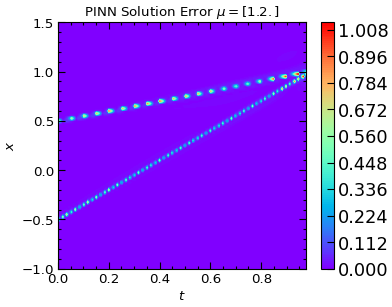

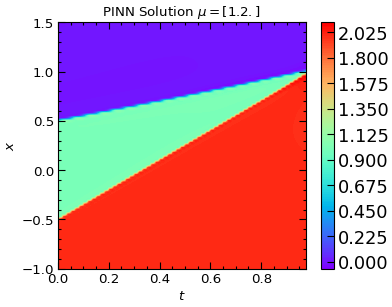

Epoch: 9200 | loss: 0.0010389576200395823,rMAE: 0.006338418927043676, rRMSE:0.029644757509231567,loss_RH:0.00000000,loss_con:4.00856018,loss_R:0.0009690634324215353,loss_IC:4.434332367964089e-06,loss_BC:2.5550834834575653e-06
Epoch: 9400 | loss: 0.0010108682326972485,rMAE: 0.005617973860353231, rRMSE:0.02885724976658821,loss_RH:0.00000000,loss_con:3.99103856,loss_R:0.0009347687009721994,loss_IC:4.874756086792331e-06,loss_BC:2.7351948119758163e-06
Epoch: 9600 | loss: 0.0010648273164406419,rMAE: 0.0057039749808609486, rRMSE:0.028913214802742004,loss_RH:0.00000000,loss_con:4.00036812,loss_R:0.0009193498990498483,loss_IC:1.278601212106878e-05,loss_BC:1.7617287539906101e-06
Epoch: 9800 | loss: 0.0009574449504725635,rMAE: 0.0055541167967021465, rRMSE:0.030002102255821228,loss_RH:0.00000000,loss_con:3.98995590,loss_R:0.0008827481651678681,loss_IC:4.0993013499246445e-06,loss_BC:3.3703747703839326e-06
Epoch: 10000 | loss: 0.0008831820450723171,rMAE: 0.005814002826809883, rRMSE:0.033277142792940

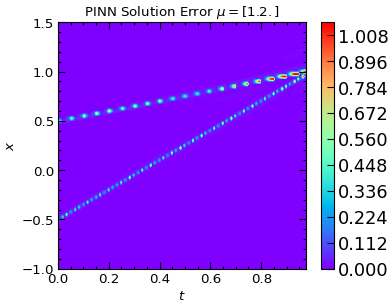

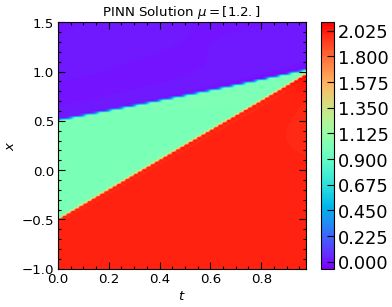

Epoch: 10200 | loss: 0.0008654535631649196,rMAE: 0.0063896398060023785, rRMSE:0.031908560544252396,loss_RH:0.00000000,loss_con:4.00576591,loss_R:0.0008273429702967405,loss_IC:2.5608464966353495e-06,loss_BC:1.2502122217483702e-06
Epoch: 10400 | loss: 0.001075773616321385,rMAE: 0.007403788156807423, rRMSE:0.03211493790149689,loss_RH:0.00000000,loss_con:4.02518129,loss_R:0.0008092794450931251,loss_IC:6.667905836366117e-06,loss_BC:1.9981507648481056e-05
Epoch: 10600 | loss: 0.000815422332379967,rMAE: 0.00523760449141264, rRMSE:0.031939078122377396,loss_RH:0.00000000,loss_con:3.99984121,loss_R:0.000789548852480948,loss_IC:2.1315061076165875e-06,loss_BC:4.5584408780996455e-07
Epoch: 10800 | loss: 0.00078604556620121,rMAE: 0.0052442788146436214, rRMSE:0.03197618946433067,loss_RH:0.00000000,loss_con:4.00017834,loss_R:0.0007663437863811851,loss_IC:1.821486875996925e-06,loss_BC:1.4869252140670142e-07
Epoch: 11000 | loss: 0.0007632909109815955,rMAE: 0.005113956518471241, rRMSE:0.03192988038063049

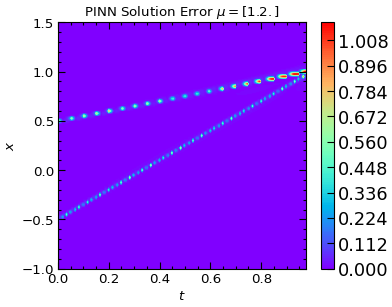

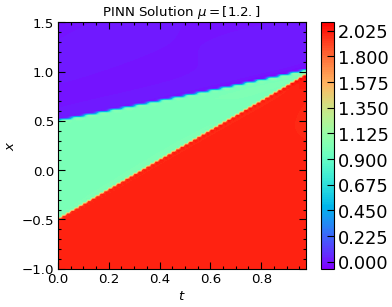

Epoch: 11200 | loss: 0.0007404134958051145,rMAE: 0.005006676074117422, rRMSE:0.03195782005786896,loss_RH:0.00000000,loss_con:4.00015163,loss_R:0.0007224183646030724,loss_IC:1.676800593486405e-06,loss_BC:1.2271189575585595e-07
Epoch: 11400 | loss: 0.000718937546480447,rMAE: 0.0050907740369439125, rRMSE:0.0318627692759037,loss_RH:0.00000000,loss_con:4.00076675,loss_R:0.0007014920702204108,loss_IC:1.6070455330918776e-06,loss_BC:1.3749973959420458e-07
Epoch: 11600 | loss: 0.0009217406623065472,rMAE: 0.007042498327791691, rRMSE:0.03165672719478607,loss_RH:0.00000000,loss_con:4.01853228,loss_R:0.0006821753340773284,loss_IC:7.206957889138721e-06,loss_BC:1.6749576388974674e-05
Epoch: 11800 | loss: 0.0006884391186758876,rMAE: 0.0051636481657624245, rRMSE:0.031830377876758575,loss_RH:0.00000000,loss_con:4.00686932,loss_R:0.0006538013112731278,loss_IC:1.885012238744821e-06,loss_BC:1.5787676375111914e-06
Epoch: 12000 | loss: 0.0006469287909567356,rMAE: 0.004720490891486406, rRMSE:0.031205169856548

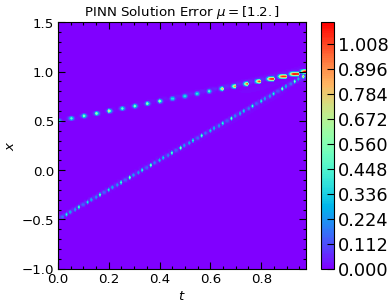

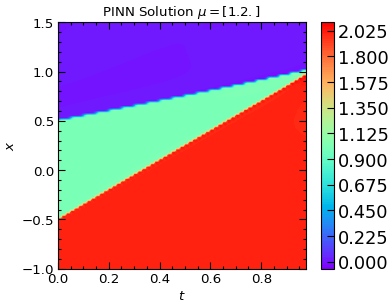

Epoch: 12200 | loss: 0.0006612616707570851,rMAE: 0.004590311087667942, rRMSE:0.02708556316792965,loss_RH:0.00000000,loss_con:3.99903011,loss_R:0.0006287775468081236,loss_IC:2.114343715220457e-06,loss_BC:1.1340689525241032e-06
Epoch: 12400 | loss: 0.0005929977633059025,rMAE: 0.004082188941538334, rRMSE:0.028199726715683937,loss_RH:0.00000000,loss_con:3.99575686,loss_R:0.0005713622667826712,loss_IC:1.4865913726680446e-06,loss_BC:6.769562332920032e-07
Epoch: 12600 | loss: 0.0006023754831403494,rMAE: 0.004033923149108887, rRMSE:0.024332508444786072,loss_RH:0.00000000,loss_con:4.00898981,loss_R:0.0005383639363572001,loss_IC:2.782362571451813e-06,loss_BC:3.618793471105164e-06
Epoch: 12800 | loss: 0.0009444353636354208,rMAE: 0.006614052690565586, rRMSE:0.024667734280228615,loss_RH:0.00000000,loss_con:4.02585077,loss_R:0.000520557165145874,loss_IC:1.1688553058775142e-05,loss_BC:3.0699266062583774e-05
Epoch: 13000 | loss: 0.0005434790509752929,rMAE: 0.0038303364999592304, rRMSE:0.02592439763247

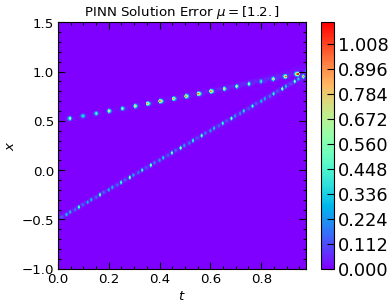

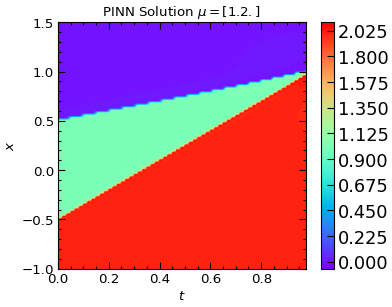

Epoch: 13200 | loss: 0.0005220833700150251,rMAE: 0.00439555523917079, rRMSE:0.03045576997101307,loss_RH:0.00000000,loss_con:3.99004650,loss_R:0.00046427984489127994,loss_IC:1.9778312889684457e-06,loss_BC:3.802520495810313e-06
Epoch: 13400 | loss: 0.0005713768769055605,rMAE: 0.004326040856540203, rRMSE:0.024791378527879715,loss_RH:0.00000000,loss_con:3.99690366,loss_R:0.00044685002649202943,loss_IC:5.111338396091014e-06,loss_BC:7.341347100009443e-06
Epoch: 13600 | loss: 0.0029857063200324774,rMAE: 0.008820556104183197, rRMSE:0.027584794908761978,loss_RH:0.00000000,loss_con:4.07924795,loss_R:0.0005064298748038709,loss_IC:5.232777402852662e-05,loss_BC:0.0001955998595803976
Epoch: 13800 | loss: 0.00044514043838717043,rMAE: 0.003385158022865653, rRMSE:0.025923503562808037,loss_RH:0.00000000,loss_con:4.00090408,loss_R:0.0004314393736422062,loss_IC:1.1861873190355254e-06,loss_BC:1.83918444918163e-07
Epoch: 14000 | loss: 0.0009724965784698725,rMAE: 0.007584863342344761, rRMSE:0.035926241427659

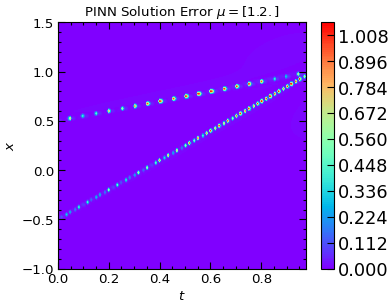

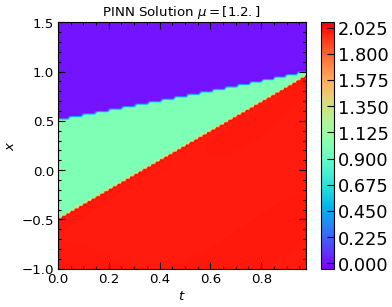

Epoch: 14200 | loss: 0.0012666410766541958,rMAE: 0.005435875616967678, rRMSE:0.02324356697499752,loss_RH:0.00000000,loss_con:3.95484757,loss_R:0.00042100317659787834,loss_IC:1.927491757669486e-05,loss_BC:6.52888702461496e-05
Epoch: 14400 | loss: 0.0007914823945611715,rMAE: 0.0059478809125721455, rRMSE:0.030629459768533707,loss_RH:0.00000000,loss_con:3.96894598,loss_R:0.00038284380570985377,loss_IC:8.843525392876472e-06,loss_BC:3.20203325827606e-05
Epoch: 14600 | loss: 0.0004090283764526248,rMAE: 0.003319474868476391, rRMSE:0.025312473997473717,loss_RH:0.00000000,loss_con:3.99264717,loss_R:0.0003669620200525969,loss_IC:2.318978658877313e-06,loss_BC:1.8876553440350108e-06
Epoch: 14800 | loss: 0.0003807730390690267,rMAE: 0.003740783780813217, rRMSE:0.02461951971054077,loss_RH:0.00000000,loss_con:4.00628424,loss_R:0.000335586752044037,loss_IC:2.101493919326458e-06,loss_BC:2.417133146082051e-06
Epoch: 15000 | loss: 0.0003893655666615814,rMAE: 0.0034279637038707733, rRMSE:0.02770901285111904

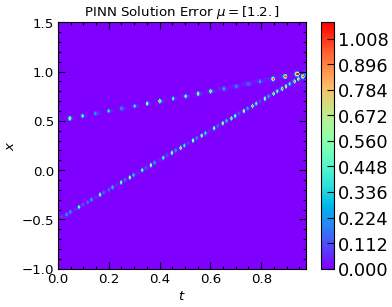

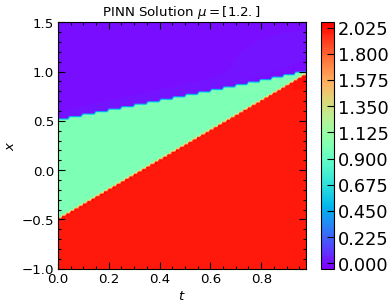

Epoch: 15200 | loss: 0.0010008977260440588,rMAE: 0.005270350258797407, rRMSE:0.030777977779507637,loss_RH:0.00000000,loss_con:3.95934343,loss_R:0.0003400146379135549,loss_IC:1.3125669283908792e-05,loss_BC:5.2962637710152194e-05
Epoch: 15400 | loss: 0.00043110456317663193,rMAE: 0.005944650154560804, rRMSE:0.047642454504966736,loss_RH:0.00000000,loss_con:4.00565815,loss_R:0.0003200909122824669,loss_IC:4.748784704133868e-06,loss_BC:6.352581749524688e-06
Epoch: 15600 | loss: 0.00044856788008473814,rMAE: 0.004629406146705151, rRMSE:0.033669352531433105,loss_RH:0.00000000,loss_con:3.98357654,loss_R:0.0002995711110997945,loss_IC:4.074832304468146e-06,loss_BC:1.0824845048773568e-05
Epoch: 15800 | loss: 0.04407527297735214,rMAE: 0.032466113567352295, rRMSE:0.0705995187163353,loss_RH:0.00000000,loss_con:4.05270767,loss_R:0.005463219713419676,loss_IC:0.0036350523587316275,loss_BC:0.0002261529298266396
Epoch: 16000 | loss: 0.002184789627790451,rMAE: 0.0075942170806229115, rRMSE:0.03104455582797527

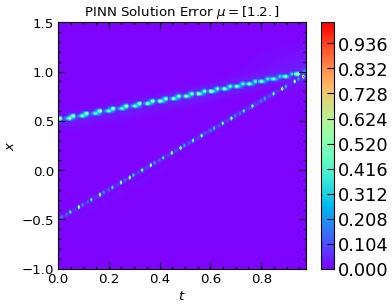

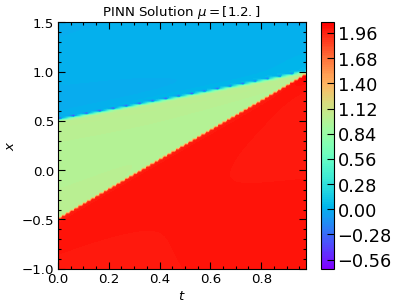

Epoch: 16200 | loss: 0.0016391496174037457,rMAE: 0.0070262569934129715, rRMSE:0.02642149291932583,loss_RH:0.00000000,loss_con:4.01431799,loss_R:0.0012346404837444425,loss_IC:3.241752347094007e-05,loss_BC:8.033385711314622e-06
Epoch: 16400 | loss: 0.0013389951782301068,rMAE: 0.005848826840519905, rRMSE:0.025744033977389336,loss_RH:0.00000000,loss_con:4.01116085,loss_R:0.0009703762480057776,loss_IC:3.235553958802484e-05,loss_BC:4.50635161541868e-06
Epoch: 16600 | loss: 0.0012516671558842063,rMAE: 0.005345555488020182, rRMSE:0.026262741535902023,loss_RH:0.00000000,loss_con:4.01591063,loss_R:0.000733700580894947,loss_IC:4.325666668592021e-05,loss_BC:8.539986993127968e-06
Epoch: 16800 | loss: 0.000439744268078357,rMAE: 0.004394379910081625, rRMSE:0.02851695381104946,loss_RH:0.00000000,loss_con:3.99646401,loss_R:0.0004138439835514873,loss_IC:1.9300198346172692e-06,loss_BC:6.60009277453355e-07
Epoch: 17000 | loss: 0.00223311735317111,rMAE: 0.009763650596141815, rRMSE:0.029941800981760025,loss

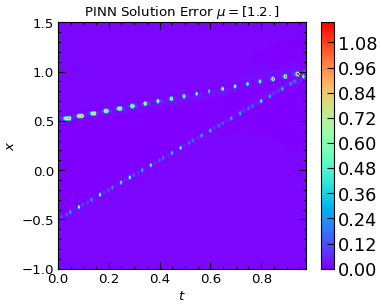

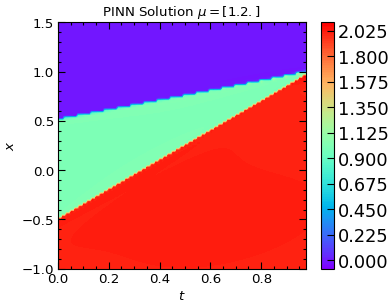

Epoch: 17200 | loss: 0.000292159675154835,rMAE: 0.0037927275989204645, rRMSE:0.030234074220061302,loss_RH:0.00000000,loss_con:3.99963617,loss_R:0.00028334857779555023,loss_IC:7.141017590583942e-07,loss_BC:1.6700670357749914e-07
Epoch: 17400 | loss: 0.00030320644145831466,rMAE: 0.0036586506757885218, rRMSE:0.030308324843645096,loss_RH:0.00000000,loss_con:3.99944735,loss_R:0.0002928274043370038,loss_IC:9.108915719480137e-07,loss_BC:1.2701265461600997e-07
Epoch: 17600 | loss: 0.0002744831144809723,rMAE: 0.003020829288288951, rRMSE:0.02575967274606228,loss_RH:0.00000000,loss_con:4.00477171,loss_R:0.0002516223175916821,loss_IC:1.4855379504297161e-06,loss_BC:8.005404197319876e-07
Epoch: 17800 | loss: 0.0014550393680110574,rMAE: 0.0074514104053378105, rRMSE:0.026000600308179855,loss_RH:0.00000000,loss_con:3.94631886,loss_R:0.0002750067797023803,loss_IC:2.691637746465858e-05,loss_BC:9.108688391279429e-05
Epoch: 18000 | loss: 0.00024409996694885194,rMAE: 0.002917008474469185, rRMSE:0.0256927926

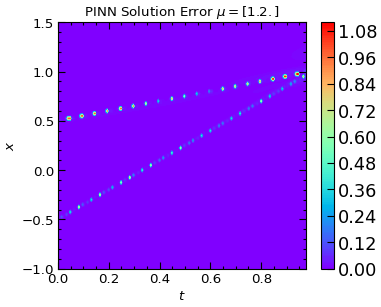

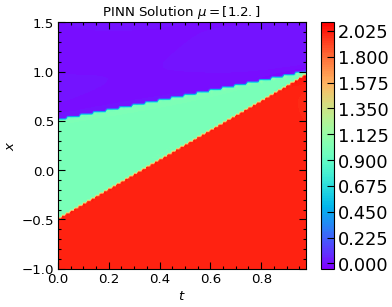

Epoch: 18200 | loss: 0.0002385950938332826,rMAE: 0.002879047067835927, rRMSE:0.025657707825303078,loss_RH:0.00000000,loss_con:3.99919176,loss_R:0.00023179293202701956,loss_IC:6.037308821760234e-07,loss_BC:7.648545619076685e-08
Epoch: 18400 | loss: 0.0002439951349515468,rMAE: 0.0033699586056172848, rRMSE:0.025707222521305084,loss_RH:0.00000000,loss_con:4.00492620,loss_R:0.00022779179562348872,loss_IC:8.105017172965745e-07,loss_BC:8.098324997263262e-07
Epoch: 18600 | loss: 0.00029175920644775033,rMAE: 0.0034291944466531277, rRMSE:0.02572326920926571,loss_RH:0.00000000,loss_con:3.98779559,loss_R:0.0002268817333970219,loss_IC:1.7806810319598299e-06,loss_BC:4.707066182163544e-06
Epoch: 18800 | loss: 0.00022450323740486056,rMAE: 0.0028201148379594088, rRMSE:0.02564990147948265,loss_RH:0.00000000,loss_con:4.00025940,loss_R:0.00022020320466253906,loss_IC:3.8785719880252145e-07,loss_BC:4.214547288938775e-08
Epoch: 19000 | loss: 0.0002350588474655524,rMAE: 0.003341920906677842, rRMSE:0.030507232

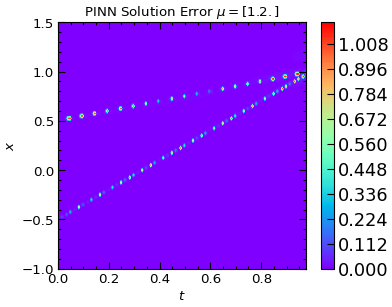

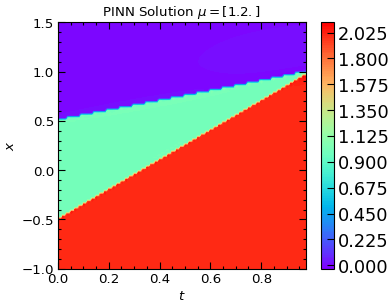

Epoch: 19200 | loss: 0.00022385563352145255,rMAE: 0.0033026195596903563, rRMSE:0.030554279685020447,loss_RH:0.00000000,loss_con:4.00083637,loss_R:0.00021899474086239934,loss_IC:3.9211286662066414e-07,loss_BC:9.397578537573281e-08
Epoch: 19400 | loss: 0.0002477499656379223,rMAE: 0.005617743358016014, rRMSE:0.044035084545612335,loss_RH:0.00000000,loss_con:4.00799274,loss_R:0.00021703276433981955,loss_IC:1.0294120329490397e-06,loss_BC:2.0423090063559357e-06
Epoch: 19600 | loss: 0.0002165679761674255,rMAE: 0.005083664786070585, rRMSE:0.04401542991399765,loss_RH:0.00000000,loss_con:4.00102615,loss_R:0.0002122609585057944,loss_IC:3.47508489539905e-07,loss_BC:8.319291566749598e-08
Epoch: 19800 | loss: 0.0005046246806159616,rMAE: 0.006696040276437998, rRMSE:0.04360096529126167,loss_RH:0.00000000,loss_con:3.97361636,loss_R:0.00022201868705451488,loss_IC:6.385408141795779e-06,loss_BC:2.1875188394915313e-05
Epoch: 20000 | loss: 0.00022075553715694696,rMAE: 0.002656293334439397, rRMSE:0.0262365005

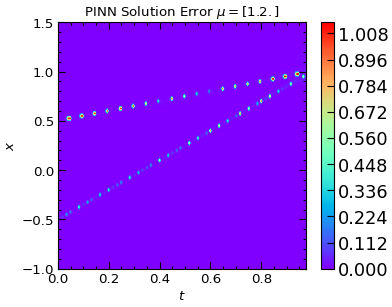

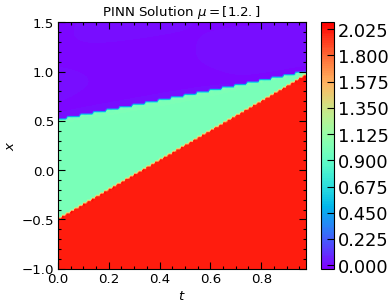

PINN Training Completed

PINN Training Time: 0.43105851870495826 Hours


In [12]:
print("******************************************************************")
########################### Full PINN Training ############################    
residual_data1 = create_residual_data(Xi, Xf, Ti, Tf, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid1      = residual_data1[0].to(device)
f_hat1         = residual_data1[1].to(device)
xt_test1       = residual_data1[2].to(device)
xt_RHL1      = residual_data1[3].to(device)
xt_RHR1      = residual_data1[4].to(device)
xt_RHt1         = residual_data1[5].to(device)
xt_RHtL1       = residual_data1[6].to(device)
ind = torch.logical_and(xt_resid1[:,0]>-1,xt_resid1[:,0]<1)

BC_data = create_BC_data(Xi, Xf, Ti, Tf, BC_pts)
BC1     = BC_data[0].to(device)
BC2     = BC_data[1].to(device)

IC_data1 = create_IC_data(nu_pinn_train,Xi, Xf, Ti, Tf, IC_pts, IC_simple)
IC_xt1     = IC_data1[0].to(device)
IC_u1      = IC_data1[1].to(device)
#plt.scatter(IC_xt[:,1].detach().cpu(),IC_xt[:,0].detach().cpu(),s=0.1)
xt_en = Move_Time_1D(IC_xt1, Tf).to(device)

Exact_y1 = exact_u(nu_pinn_train,xt_test1)[:,None].to(device)
###   IFNN2 training   ####
pinn_train_time_1 = time.perf_counter()

PINN1 = NN1(nu_pinn_train, layers_pinn,dt).to(device)
    
pinn1_losses = pinn1_train(PINN1, nu_pinn_train, xt_resid1, IC_xt1, IC_u1, BC1, BC2, xt_RHL1,xt_RHR1,xt_RHt1,xt_RHtL1, f_hat1, Exact_y1, epochs_pinn1, lr_pinn1, tol_pinn1, xt_test1)

pinn_train_time_2 = time.perf_counter()
print(f"PINN Training Time: {(pinn_train_time_2-pinn_train_time_1)/3600} Hours")

Epoch: 200 | loss: 2.5121777057647705,rMAE: 0.3899022936820984, rRMSE:0.47163790464401245,loss_RH:0.00000000,loss_con:4.08253956,loss_R:0.7536092400550842,loss_IC:0.16110160946846008,loss_BC:0.014755242504179478
Epoch: 400 | loss: 1.697359323501587,rMAE: 0.3990379273891449, rRMSE:0.482279896736145,loss_RH:0.00000000,loss_con:4.13307428,loss_R:0.7710720300674438,loss_IC:0.08697950839996338,loss_BC:0.005649218335747719
Epoch: 600 | loss: 1.6364415884017944,rMAE: 0.3934451937675476, rRMSE:0.4764419198036194,loss_RH:0.00000000,loss_con:4.10539293,loss_R:0.7509633302688599,loss_IC:0.08442399650812149,loss_BC:0.004123828373849392
Epoch: 800 | loss: 1.589830994606018,rMAE: 0.3819584846496582, rRMSE:0.46470025181770325,loss_RH:0.00000000,loss_con:4.06305838,loss_R:0.7163491249084473,loss_IC:0.08366749435663223,loss_BC:0.003680689726024866
Epoch: 1000 | loss: 1.541008710861206,rMAE: 0.36631089448928833, rRMSE:0.449194073677063,loss_RH:0.00000000,loss_con:4.01288509,loss_R:0.6704197525978088,los

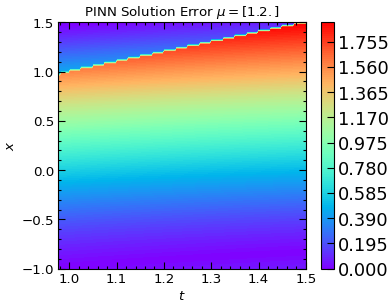

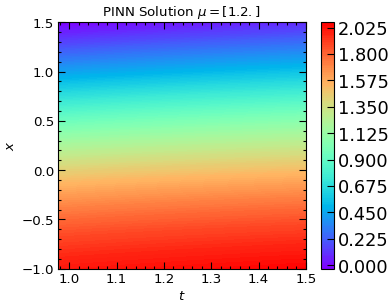

Epoch: 1200 | loss: 1.4950344562530518,rMAE: 0.34656694531440735, rRMSE:0.4306442439556122,loss_RH:0.00000000,loss_con:3.96659327,loss_R:0.616626501083374,loss_IC:0.08444540202617645,loss_BC:0.0033954002428799868
Epoch: 1400 | loss: 1.448108434677124,rMAE: 0.3236868679523468, rRMSE:0.4107864201068878,loss_RH:0.00000000,loss_con:3.93404722,loss_R:0.5593786239624023,loss_IC:0.08540995419025421,loss_BC:0.0034630214795470238
Epoch: 1600 | loss: 1.3944568634033203,rMAE: 0.2987356185913086, rRMSE:0.3910635709762573,loss_RH:0.00000000,loss_con:3.91353488,loss_R:0.5034690499305725,loss_IC:0.08563386648893356,loss_BC:0.0034649057779461145
Epoch: 1800 | loss: 1.330606460571289,rMAE: 0.2724924087524414, rRMSE:0.37182170152664185,loss_RH:0.00000000,loss_con:3.90025973,loss_R:0.4509643018245697,loss_IC:0.08462091535329819,loss_BC:0.003343297867104411
Epoch: 2000 | loss: 1.2538870573043823,rMAE: 0.2469678670167923, rRMSE:0.35265183448791504,loss_RH:0.00000000,loss_con:3.89620519,loss_R:0.40080246329

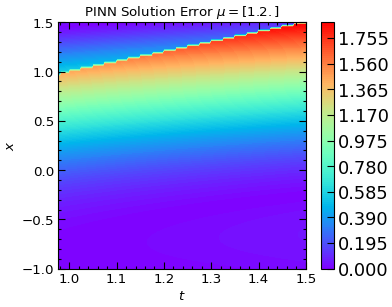

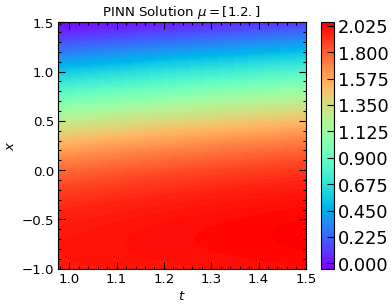

Epoch: 2200 | loss: 1.1688379049301147,rMAE: 0.22548255324363708, rRMSE:0.332386314868927,loss_RH:0.00000000,loss_con:3.90591288,loss_R:0.3522197902202606,loss_IC:0.07892227917909622,loss_BC:0.0027395302895456553
Epoch: 2400 | loss: 1.0883594751358032,rMAE: 0.20830929279327393, rRMSE:0.31037694215774536,loss_RH:0.00000000,loss_con:3.92907667,loss_R:0.30471286177635193,loss_IC:0.0757787898182869,loss_BC:0.0025858678855001926
Epoch: 2600 | loss: 1.0289819240570068,rMAE: 0.1959194391965866, rRMSE:0.28870171308517456,loss_RH:0.00000000,loss_con:3.95713806,loss_R:0.2629609704017639,loss_IC:0.07377485930919647,loss_BC:0.002827235497534275
Epoch: 2800 | loss: 0.9931426048278809,rMAE: 0.18865224719047546, rRMSE:0.27093589305877686,loss_RH:0.00000000,loss_con:3.97904229,loss_R:0.2323523908853531,loss_IC:0.07283903658390045,loss_BC:0.0032399867195636034
Epoch: 3000 | loss: 0.9710674285888672,rMAE: 0.18464526534080505, rRMSE:0.25826743245124817,loss_RH:0.00000000,loss_con:3.99135303,loss_R:0.2132

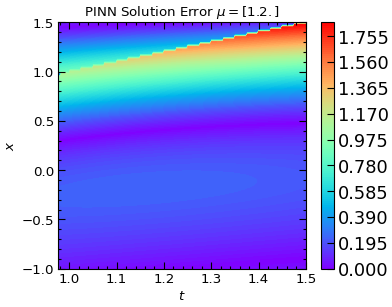

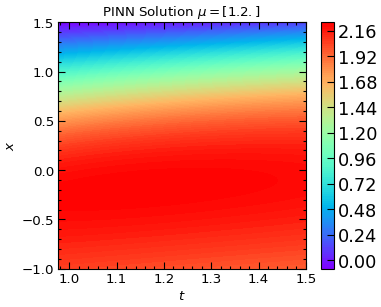

Epoch: 3200 | loss: 0.9533214569091797,rMAE: 0.1813240647315979, rRMSE:0.24926872551441193,loss_RH:0.00000000,loss_con:3.99633121,loss_R:0.20046618580818176,loss_IC:0.07201477140188217,loss_BC:0.0032707613427191973
Epoch: 3400 | loss: 0.9358018040657043,rMAE: 0.17703942954540253, rRMSE:0.24207206070423126,loss_RH:0.00000000,loss_con:3.99708271,loss_R:0.19035939872264862,loss_IC:0.07165626436471939,loss_BC:0.002887969370931387
Epoch: 3600 | loss: 0.9168328642845154,rMAE: 0.17119966447353363, rRMSE:0.23542208969593048,loss_RH:0.00000000,loss_con:3.99576402,loss_R:0.1807904988527298,loss_IC:0.07126560807228088,loss_BC:0.0023386364337056875
Epoch: 3800 | loss: 0.8965017199516296,rMAE: 0.16396328806877136, rRMSE:0.228763610124588,loss_RH:0.00000000,loss_con:3.99364877,loss_R:0.17120115458965302,loss_IC:0.07082931697368622,loss_BC:0.0017007370479404926
Epoch: 4000 | loss: 0.8759207129478455,rMAE: 0.15584313869476318, rRMSE:0.22202551364898682,loss_RH:0.00000000,loss_con:3.99111390,loss_R:0.1

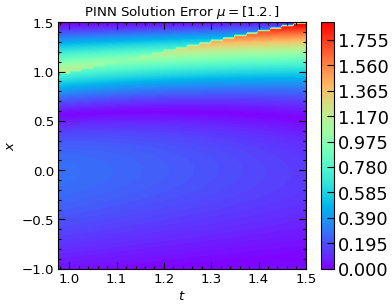

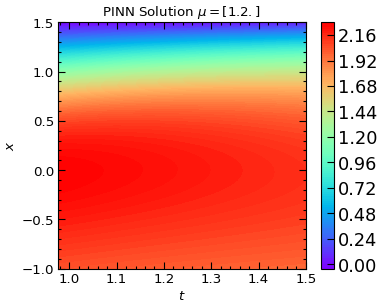

Epoch: 4200 | loss: 0.8564185500144958,rMAE: 0.1474541425704956, rRMSE:0.21536056697368622,loss_RH:0.00000000,loss_con:3.98899651,loss_R:0.15282757580280304,loss_IC:0.06974593549966812,loss_BC:0.0006131628761067986
Epoch: 4400 | loss: 0.8385543823242188,rMAE: 0.13926070928573608, rRMSE:0.2088789939880371,loss_RH:0.00000000,loss_con:3.98759127,loss_R:0.14388392865657806,loss_IC:0.06914666295051575,loss_BC:0.0003203835804015398
Epoch: 4600 | loss: 0.8218920826911926,rMAE: 0.13128556311130524, rRMSE:0.20264719426631927,loss_RH:0.00000000,loss_con:3.98712111,loss_R:0.13489536941051483,loss_IC:0.06852443516254425,loss_BC:0.00017523829592391849
Epoch: 4800 | loss: 0.8056694269180298,rMAE: 0.12304765731096268, rRMSE:0.19649849832057953,loss_RH:0.00000000,loss_con:3.98711348,loss_R:0.12646973133087158,loss_IC:0.06779970228672028,loss_BC:0.00012026606418658048
Epoch: 5000 | loss: 0.7864943146705627,rMAE: 0.1137668564915657, rRMSE:0.19014237821102142,loss_RH:0.00000000,loss_con:3.98805356,loss_R

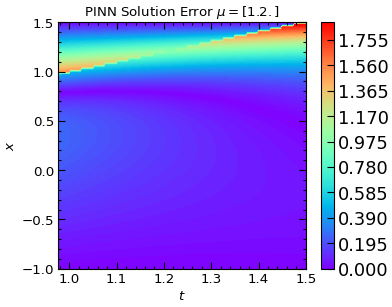

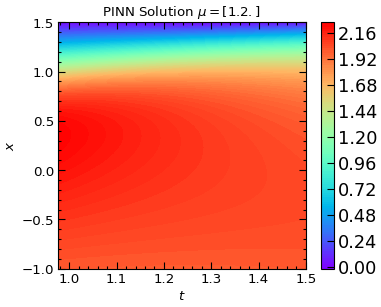

Epoch: 5200 | loss: 0.7611506581306458,rMAE: 0.10270015895366669, rRMSE:0.18336403369903564,loss_RH:0.00000000,loss_con:3.99063563,loss_R:0.10665591061115265,loss_IC:0.06534921377897263,loss_BC:0.00010025945084635168
Epoch: 5400 | loss: 0.7235009074211121,rMAE: 0.09067851305007935, rRMSE:0.17629028856754303,loss_RH:0.00000000,loss_con:3.99657512,loss_R:0.09597238153219223,loss_IC:0.06267016381025314,loss_BC:8.26904724817723e-05
Epoch: 5600 | loss: 0.6628009676933289,rMAE: 0.08379378914833069, rRMSE:0.16955721378326416,loss_RH:0.00000000,loss_con:4.00767422,loss_R:0.08670910447835922,loss_IC:0.05755782499909401,loss_BC:5.136455001775175e-05
Epoch: 5800 | loss: 0.5755704641342163,rMAE: 0.08128789812326431, rRMSE:0.16248741745948792,loss_RH:0.00000000,loss_con:4.01676416,loss_R:0.07884261012077332,loss_IC:0.04961519315838814,loss_BC:5.7594283134676516e-05
Epoch: 6000 | loss: 0.4805320203304291,rMAE: 0.07445821911096573, rRMSE:0.15288780629634857,loss_RH:0.00000000,loss_con:4.01353455,loss

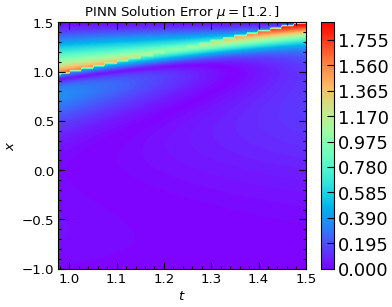

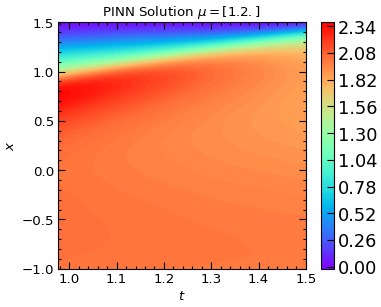

Epoch: 6200 | loss: 0.40753310918807983,rMAE: 0.06654930114746094, rRMSE:0.1428866684436798,loss_RH:0.00000000,loss_con:4.00311899,loss_R:0.06038207188248634,loss_IC:0.034515030682086945,loss_BC:0.0002000739041250199
Epoch: 6400 | loss: 0.3556509017944336,rMAE: 0.06220433488488197, rRMSE:0.13538400828838348,loss_RH:0.00000000,loss_con:3.99532557,loss_R:0.05205808952450752,loss_IC:0.030060667544603348,loss_BC:0.0002986110339406878
Epoch: 6600 | loss: 0.3112517297267914,rMAE: 0.05733959376811981, rRMSE:0.12889118492603302,loss_RH:0.00000000,loss_con:3.99483418,loss_R:0.04475155845284462,loss_IC:0.02635062113404274,loss_BC:0.0002993980306200683
Epoch: 6800 | loss: 0.27299052476882935,rMAE: 0.05100300535559654, rRMSE:0.12156129628419876,loss_RH:0.00000000,loss_con:4.00114155,loss_R:0.03802729398012161,loss_IC:0.023275025188922882,loss_BC:0.00022129838180262595
Epoch: 7000 | loss: 0.24071797728538513,rMAE: 0.04692598804831505, rRMSE:0.11538378149271011,loss_RH:0.00000000,loss_con:4.00700378

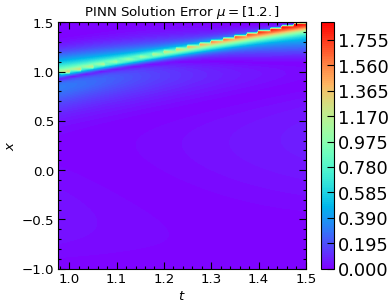

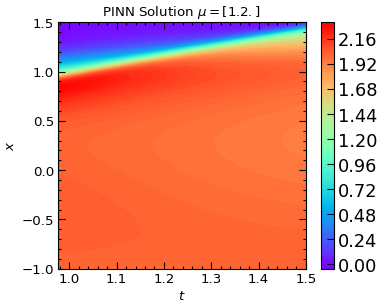

Epoch: 7200 | loss: 0.20991800725460052,rMAE: 0.04438511282205582, rRMSE:0.11016293615102768,loss_RH:0.00000000,loss_con:4.00879669,loss_R:0.029456142336130142,loss_IC:0.01791071705520153,loss_BC:0.00013546955597121269
Epoch: 7400 | loss: 0.17932936549186707,rMAE: 0.04088525474071503, rRMSE:0.10600947588682175,loss_RH:0.00000000,loss_con:4.00742769,loss_R:0.026799554005265236,loss_IC:0.015147495083510876,loss_BC:0.00010548665886744857
Epoch: 7600 | loss: 0.15242667496204376,rMAE: 0.035911574959754944, rRMSE:0.10169878602027893,loss_RH:0.00000000,loss_con:4.00482702,loss_R:0.02413453720510006,loss_IC:0.012745271436870098,loss_BC:8.394245378440246e-05
Epoch: 7800 | loss: 0.13288535177707672,rMAE: 0.031760361045598984, rRMSE:0.09765733033418655,loss_RH:0.00000000,loss_con:3.99957943,loss_R:0.021704064682126045,loss_IC:0.011042697355151176,loss_BC:7.543050014646724e-05
Epoch: 8000 | loss: 0.1197323426604271,rMAE: 0.02916954830288887, rRMSE:0.09357593953609467,loss_RH:0.00000000,loss_con:3.

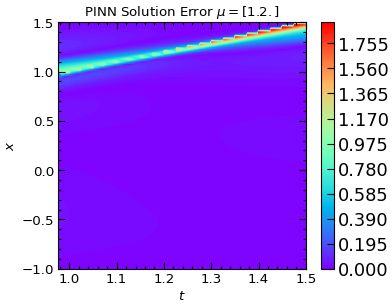

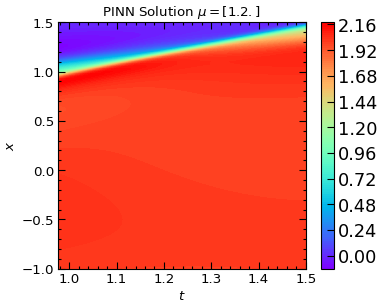

Epoch: 8200 | loss: 0.10954348742961884,rMAE: 0.02761656977236271, rRMSE:0.09033546596765518,loss_RH:0.00000000,loss_con:3.99963713,loss_R:0.017273176461458206,loss_IC:0.009153644554316998,loss_BC:7.338714203797281e-05
Epoch: 8400 | loss: 0.10080668330192566,rMAE: 0.026734044775366783, rRMSE:0.08827199786901474,loss_RH:0.00000000,loss_con:3.99770141,loss_R:0.015567059628665447,loss_IC:0.008460192941129208,loss_BC:6.376965757226571e-05
Epoch: 8600 | loss: 0.092787966132164,rMAE: 0.025846537202596664, rRMSE:0.0852055549621582,loss_RH:0.00000000,loss_con:3.99629402,loss_R:0.01422557607293129,loss_IC:0.007792501710355282,loss_BC:6.373801443260163e-05
Epoch: 8800 | loss: 0.08502303063869476,rMAE: 0.02533917874097824, rRMSE:0.08387871086597443,loss_RH:0.00000000,loss_con:3.99656892,loss_R:0.01299195270985365,loss_IC:0.0071485755033791065,loss_BC:5.453282574308105e-05
Epoch: 9000 | loss: 0.07834228873252869,rMAE: 0.024204159155488014, rRMSE:0.08104728907346725,loss_RH:0.00000000,loss_con:4.02

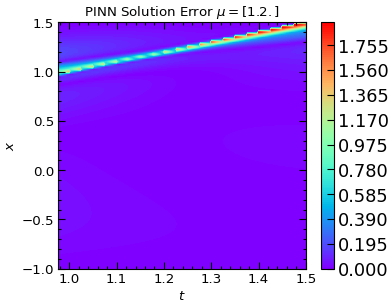

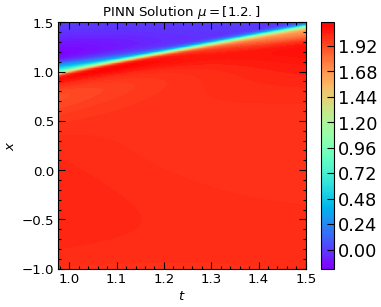

Epoch: 9200 | loss: 0.071151964366436,rMAE: 0.023962650448083878, rRMSE:0.07883866131305695,loss_RH:0.00000000,loss_con:3.99804473,loss_R:0.01124562043696642,loss_IC:0.005935840308666229,loss_BC:5.479367246152833e-05
Epoch: 9400 | loss: 0.06463541835546494,rMAE: 0.023323234170675278, rRMSE:0.0761931762099266,loss_RH:0.00000000,loss_con:3.99479890,loss_R:0.01055166032165289,loss_IC:0.00535298278555274,loss_BC:5.5392774811480194e-05
Epoch: 9600 | loss: 0.0582093708217144,rMAE: 0.022501148283481598, rRMSE:0.07282976061105728,loss_RH:0.00000000,loss_con:3.99425387,loss_R:0.009736928157508373,loss_IC:0.004790547303855419,loss_BC:5.669689562637359e-05
Epoch: 9800 | loss: 0.052178382873535156,rMAE: 0.021722925826907158, rRMSE:0.06974561512470245,loss_RH:0.00000000,loss_con:3.99609947,loss_R:0.009054145775735378,loss_IC:0.004259686451405287,loss_BC:5.273720671539195e-05
Epoch: 10000 | loss: 0.04636756703257561,rMAE: 0.020587589591741562, rRMSE:0.06503785401582718,loss_RH:0.00000000,loss_con:3.

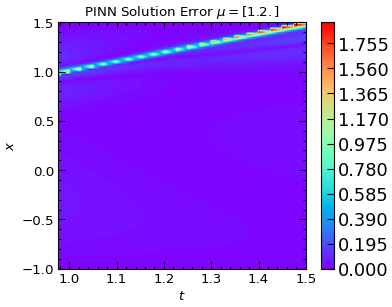

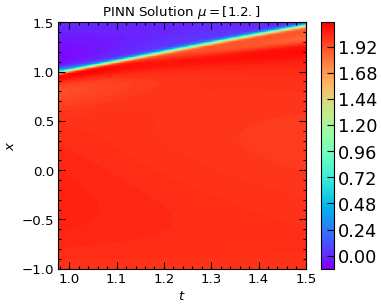

Epoch: 10200 | loss: 0.04130322113633156,rMAE: 0.019356677308678627, rRMSE:0.06245175749063492,loss_RH:0.00000000,loss_con:4.00026131,loss_R:0.007510512601584196,loss_IC:0.0033295108005404472,loss_BC:4.9760106776375324e-05
Epoch: 10400 | loss: 0.036660317331552505,rMAE: 0.018482724204659462, rRMSE:0.05956059694290161,loss_RH:0.00000000,loss_con:3.97672606,loss_R:0.006694846320897341,loss_IC:0.0029315375722944736,loss_BC:6.500953168142587e-05
Epoch: 10600 | loss: 0.03248056396842003,rMAE: 0.016867535188794136, rRMSE:0.057702045887708664,loss_RH:0.00000000,loss_con:3.98646164,loss_R:0.006318512372672558,loss_IC:0.002567458897829056,loss_BC:4.874645310337655e-05
Epoch: 10800 | loss: 0.028755318373441696,rMAE: 0.016208287328481674, rRMSE:0.05675670877099037,loss_RH:0.00000000,loss_con:3.99646354,loss_R:0.006017707753926516,loss_IC:0.002237082226201892,loss_BC:3.667894270620309e-05
Epoch: 11000 | loss: 0.025334442034363747,rMAE: 0.015381107106804848, rRMSE:0.05491776019334793,loss_RH:0.0000

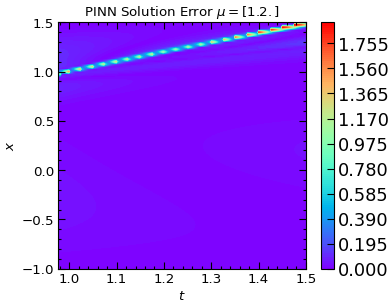

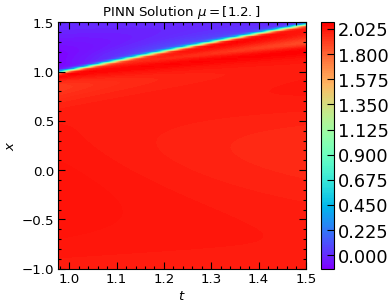

Epoch: 11200 | loss: 0.022175457328557968,rMAE: 0.015056204050779343, rRMSE:0.05446004867553711,loss_RH:0.00000000,loss_con:3.98589897,loss_R:0.005267668515443802,loss_IC:0.0016558265779167414,loss_BC:3.495236160233617e-05
Epoch: 11400 | loss: 0.019061831757426262,rMAE: 0.01369052566587925, rRMSE:0.05343249440193176,loss_RH:0.00000000,loss_con:3.99922609,loss_R:0.004789525642991066,loss_IC:0.0014028933364897966,loss_BC:2.433733425277751e-05
Epoch: 11600 | loss: 0.017074521631002426,rMAE: 0.01365175936371088, rRMSE:0.05222323536872864,loss_RH:0.00000000,loss_con:3.96347690,loss_R:0.004633408039808273,loss_IC:0.0011804334353655577,loss_BC:6.367807509377599e-05
Epoch: 11800 | loss: 0.014207120053470135,rMAE: 0.011968310922384262, rRMSE:0.05160314589738846,loss_RH:0.00000000,loss_con:3.99875784,loss_R:0.004371971823275089,loss_IC:0.0009669107967056334,loss_BC:1.660403904679697e-05
Epoch: 12000 | loss: 0.012105729430913925,rMAE: 0.011031818576157093, rRMSE:0.05120992660522461,loss_RH:0.0000

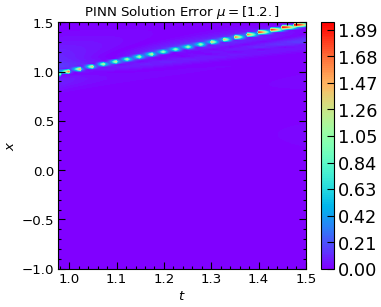

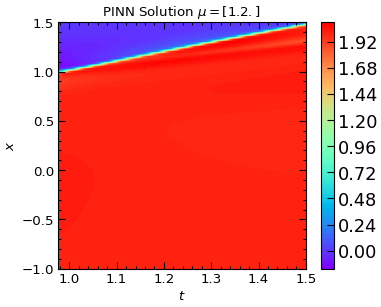

Epoch: 12200 | loss: 0.010431593284010887,rMAE: 0.010149345733225346, rRMSE:0.050797607749700546,loss_RH:0.00000000,loss_con:3.99944067,loss_R:0.004049173556268215,loss_IC:0.0006289173616096377,loss_BC:9.324587153969333e-06
Epoch: 12400 | loss: 0.009103856980800629,rMAE: 0.009397276677191257, rRMSE:0.04973021149635315,loss_RH:0.00000000,loss_con:3.99979496,loss_R:0.0040418002754449844,loss_IC:0.0004985278937965631,loss_BC:7.67778510635253e-06
Epoch: 12600 | loss: 0.007992364466190338,rMAE: 0.00907981302589178, rRMSE:0.04944993928074837,loss_RH:0.00000000,loss_con:4.00000191,loss_R:0.004004943650215864,loss_IC:0.0003932981926482171,loss_BC:5.4438423831015825e-06
Epoch: 12800 | loss: 0.007027161307632923,rMAE: 0.008910240605473518, rRMSE:0.04883187264204025,loss_RH:0.00000000,loss_con:4.00042915,loss_R:0.0038747431244701147,loss_IC:0.000310987961711362,loss_BC:4.253831320966128e-06
Epoch: 13000 | loss: 0.006334507837891579,rMAE: 0.0087331123650074, rRMSE:0.047422491014003754,loss_RH:0.00

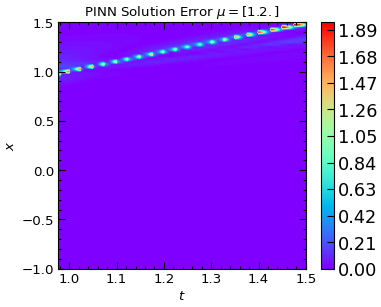

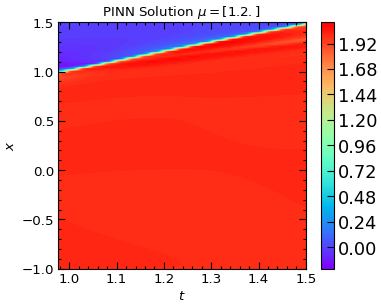

Epoch: 13200 | loss: 0.005789650604128838,rMAE: 0.008658869192004204, rRMSE:0.046945780515670776,loss_RH:0.00000000,loss_con:4.00227880,loss_R:0.003749883035197854,loss_IC:0.00020047370344400406,loss_BC:3.5030464005103568e-06
Epoch: 13400 | loss: 0.005143360234797001,rMAE: 0.00848472211509943, rRMSE:0.04578651860356331,loss_RH:0.00000000,loss_con:3.99889374,loss_R:0.0034470772370696068,loss_IC:0.00016475038137286901,loss_BC:4.877904757449869e-06
Epoch: 13600 | loss: 0.004742432851344347,rMAE: 0.008400697261095047, rRMSE:0.04547933489084244,loss_RH:0.00000000,loss_con:4.00003910,loss_R:0.0033311278093606234,loss_IC:0.0001373454724671319,loss_BC:3.7850390981475357e-06
Epoch: 13800 | loss: 0.004483085125684738,rMAE: 0.008192481473088264, rRMSE:0.044282570481300354,loss_RH:0.00000000,loss_con:3.99961901,loss_R:0.0032687790226191282,loss_IC:0.00011643522884696722,loss_BC:4.99540556120337e-06
Epoch: 14000 | loss: 0.00435580313205719,rMAE: 0.008017770014703274, rRMSE:0.04328073561191559,loss_

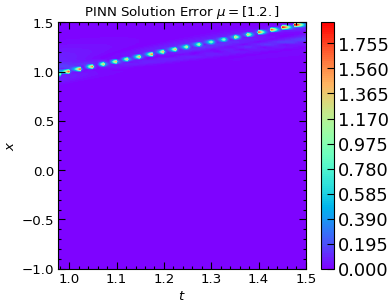

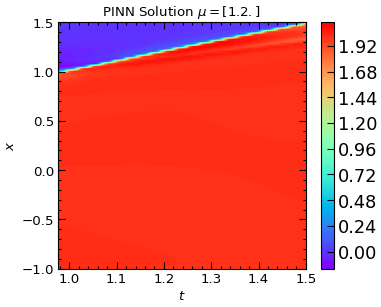

Epoch: 14200 | loss: 0.00410392927005887,rMAE: 0.007886689156293869, rRMSE:0.0431264266371727,loss_RH:0.00000000,loss_con:4.00217581,loss_R:0.003194007556885481,loss_IC:8.598589192843065e-05,loss_BC:5.006295850762399e-06
Epoch: 14400 | loss: 0.0038773133419454098,rMAE: 0.00773413572460413, rRMSE:0.0429876446723938,loss_RH:0.00000000,loss_con:4.00223780,loss_R:0.0030880968552082777,loss_IC:7.436337909894064e-05,loss_BC:4.558253294817405e-06
Epoch: 14600 | loss: 0.003669065423309803,rMAE: 0.007564910687506199, rRMSE:0.042856957763433456,loss_RH:0.00000000,loss_con:4.00049305,loss_R:0.002985062776133418,loss_IC:6.436765397666022e-05,loss_BC:4.032619472127408e-06
Epoch: 14800 | loss: 0.003477400867268443,rMAE: 0.007408867124468088, rRMSE:0.042737241834402084,loss_RH:0.00000000,loss_con:4.00070286,loss_R:0.002884302753955126,loss_IC:5.56279846932739e-05,loss_BC:3.681833277369151e-06
Epoch: 15000 | loss: 0.0033086962066590786,rMAE: 0.007151445839554071, rRMSE:0.04154009371995926,loss_RH:0.00

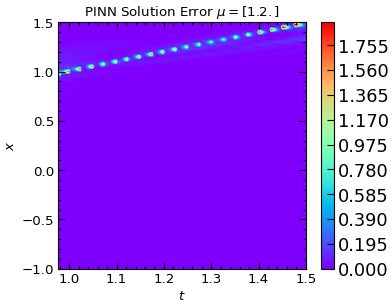

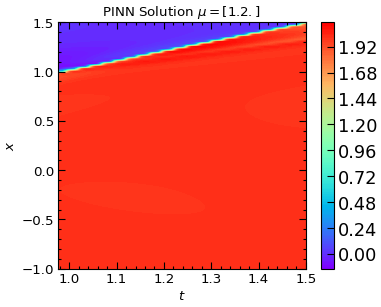

Epoch: 15200 | loss: 0.003266626037657261,rMAE: 0.007124324329197407, rRMSE:0.04156234487891197,loss_RH:0.00000000,loss_con:4.00013924,loss_R:0.002753518521785736,loss_IC:4.647933747037314e-05,loss_BC:4.831407295569079e-06
Epoch: 15400 | loss: 0.00321044959127903,rMAE: 0.007073582150042057, rRMSE:0.041512589901685715,loss_RH:0.00000000,loss_con:4.00013638,loss_R:0.0027211953420192003,loss_IC:4.426188752404414e-05,loss_BC:4.663535491999937e-06
Epoch: 15600 | loss: 0.00314719183370471,rMAE: 0.007011792156845331, rRMSE:0.04146125912666321,loss_RH:0.00000000,loss_con:4.00013733,loss_R:0.002684168517589569,loss_IC:4.180989708402194e-05,loss_BC:4.492441348702414e-06
Epoch: 15800 | loss: 0.003079288639128208,rMAE: 0.006941893137991428, rRMSE:0.041408050805330276,loss_RH:0.00000000,loss_con:4.00011539,loss_R:0.0026439037173986435,loss_IC:3.923489202861674e-05,loss_BC:4.303611603972968e-06
Epoch: 16000 | loss: 0.003007947001606226,rMAE: 0.006866554729640484, rRMSE:0.04135575890541077,loss_RH:0.

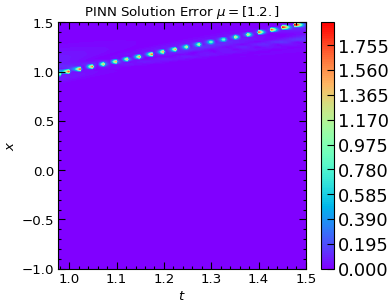

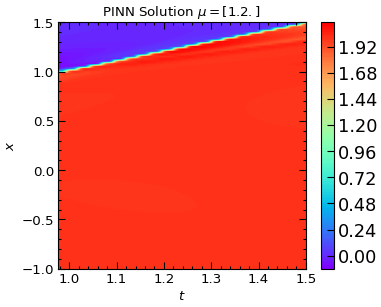

Epoch: 16200 | loss: 0.0029343287460505962,rMAE: 0.006787489168345928, rRMSE:0.041303813457489014,loss_RH:0.00000000,loss_con:4.00009441,loss_R:0.0025562066584825516,loss_IC:3.39018770318944e-05,loss_BC:3.910342911694897e-06
Epoch: 16400 | loss: 0.0028591167647391558,rMAE: 0.006706347223371267, rRMSE:0.04125744849443436,loss_RH:0.00000000,loss_con:4.00006199,loss_R:0.002510102465748787,loss_IC:3.120413384749554e-05,loss_BC:3.6972951420466416e-06
Epoch: 16600 | loss: 0.002751037012785673,rMAE: 0.0065975855104625225, rRMSE:0.04085612669587135,loss_RH:0.00000000,loss_con:4.00001812,loss_R:0.002427972387522459,loss_IC:2.858789412130136e-05,loss_BC:3.7185805012995843e-06
Epoch: 16800 | loss: 0.0026730592362582684,rMAE: 0.006503639277070761, rRMSE:0.04068829119205475,loss_RH:0.00000000,loss_con:4.00010109,loss_R:0.002376948483288288,loss_IC:2.601987580419518e-05,loss_BC:3.59121054316347e-06
Epoch: 17000 | loss: 0.002597142942249775,rMAE: 0.006424761842936277, rRMSE:0.0406411848962307,loss_RH

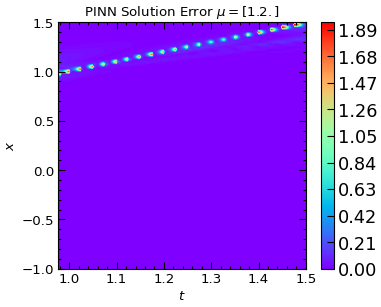

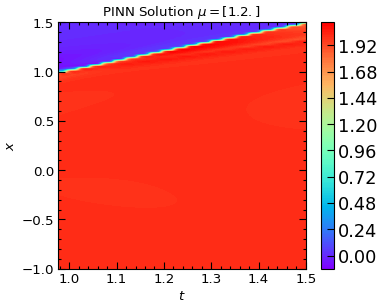

Epoch: 17200 | loss: 0.00252538756467402,rMAE: 0.006344555877149105, rRMSE:0.04059387743473053,loss_RH:0.00000000,loss_con:4.00176525,loss_R:0.0022808420471847057,loss_IC:2.12360992009053e-05,loss_BC:3.2184429983317386e-06
Epoch: 17400 | loss: 0.002454564440995455,rMAE: 0.006277017295360565, rRMSE:0.040558625012636185,loss_RH:0.00000000,loss_con:4.00000668,loss_R:0.002234791172668338,loss_IC:1.9072851500823162e-05,loss_BC:2.90448610940075e-06
Epoch: 17600 | loss: 0.0023884389083832502,rMAE: 0.0062120044603943825, rRMSE:0.04052744060754776,loss_RH:0.00000000,loss_con:3.99898767,loss_R:0.0021899451967328787,loss_IC:1.71417195815593e-05,loss_BC:2.7076503101852722e-06
Epoch: 17800 | loss: 0.002324993722140789,rMAE: 0.006142494734376669, rRMSE:0.040499262511730194,loss_RH:0.00000000,loss_con:3.99998045,loss_R:0.0021461467258632183,loss_IC:1.541750316391699e-05,loss_BC:2.4672003746673e-06
Epoch: 18000 | loss: 0.0022655436769127846,rMAE: 0.006077569909393787, rRMSE:0.04048226773738861,loss_RH

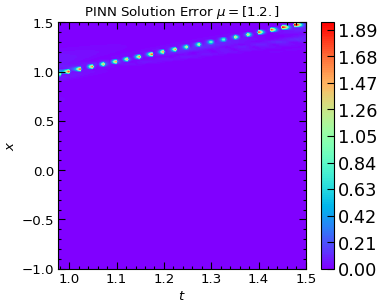

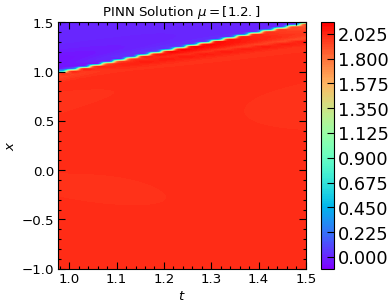

Epoch: 18200 | loss: 0.00233307178132236,rMAE: 0.005987229291349649, rRMSE:0.0400938056409359,loss_RH:0.00000000,loss_con:3.99998713,loss_R:0.002181720919907093,loss_IC:1.2696671547018923e-05,loss_BC:2.438413048366783e-06
Epoch: 18400 | loss: 0.0022812499664723873,rMAE: 0.005929857492446899, rRMSE:0.0400722436606884,loss_RH:0.00000000,loss_con:4.00019741,loss_R:0.0021425061859190464,loss_IC:1.163159504358191e-05,loss_BC:2.2427830117521808e-06
Epoch: 18600 | loss: 0.0022325238678604364,rMAE: 0.00587574252858758, rRMSE:0.040057409554719925,loss_RH:0.00000000,loss_con:4.00024414,loss_R:0.00210484117269516,loss_IC:1.0718659723352175e-05,loss_BC:2.049613158305874e-06
Epoch: 18800 | loss: 0.0021865128073841333,rMAE: 0.005829243455082178, rRMSE:0.04005253314971924,loss_RH:0.00000000,loss_con:3.99957037,loss_R:0.002068423666059971,loss_IC:9.939515621226747e-06,loss_BC:1.8694003074415377e-06
Epoch: 19000 | loss: 0.0021430421620607376,rMAE: 0.005781815852969885, rRMSE:0.04004647582769394,loss_RH

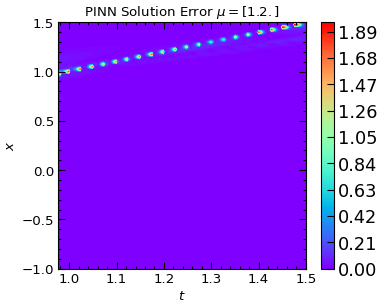

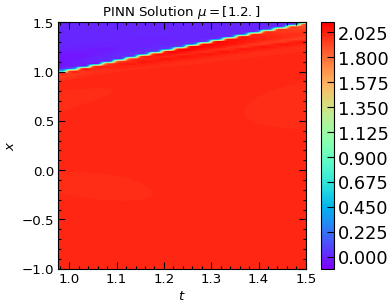

Epoch: 19200 | loss: 0.0021018830593675375,rMAE: 0.0057319775223731995, rRMSE:0.04004930704832077,loss_RH:0.00000000,loss_con:3.99995947,loss_R:0.0019994848407804966,loss_IC:8.711607733857818e-06,loss_BC:1.5282064396160422e-06
Epoch: 19400 | loss: 0.0020629188511520624,rMAE: 0.005692044273018837, rRMSE:0.04005345329642296,loss_RH:0.00000000,loss_con:3.99934673,loss_R:0.001966850133612752,loss_IC:8.214632543968037e-06,loss_BC:1.3922365269536385e-06
Epoch: 19600 | loss: 0.002025853144004941,rMAE: 0.005655250046402216, rRMSE:0.04005686566233635,loss_RH:0.00000000,loss_con:3.99922228,loss_R:0.001935466076247394,loss_IC:7.774876394250896e-06,loss_BC:1.2638397492992226e-06
Epoch: 19800 | loss: 0.0019900936167687178,rMAE: 0.005613015964627266, rRMSE:0.04007324203848839,loss_RH:0.00000000,loss_con:3.99977016,loss_R:0.0019051010021939874,loss_IC:7.377946076303488e-06,loss_BC:1.1213078323635273e-06
Epoch: 20000 | loss: 0.0019564791582524776,rMAE: 0.005579560995101929, rRMSE:0.04008891060948372,l

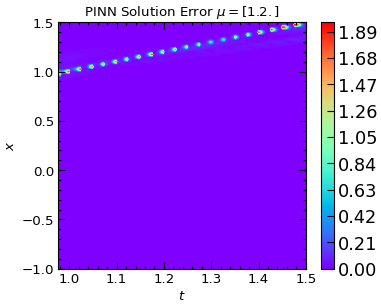

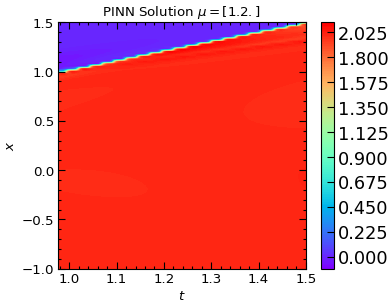

Epoch: 20200 | loss: 0.0019241668051108718,rMAE: 0.005544212181121111, rRMSE:0.040101904422044754,loss_RH:0.00000000,loss_con:4.00017452,loss_R:0.0018480229191482067,loss_IC:6.692064744129311e-06,loss_BC:9.223247730005824e-07
Epoch: 20400 | loss: 0.0018931666854768991,rMAE: 0.00551528250798583, rRMSE:0.04012369364500046,loss_RH:0.00000000,loss_con:4.00007439,loss_R:0.0018209670670330524,loss_IC:6.383164873113856e-06,loss_BC:8.3680168927458e-07
Epoch: 20600 | loss: 0.0018642768263816833,rMAE: 0.005476522725075483, rRMSE:0.04014762118458748,loss_RH:0.00000000,loss_con:4.00147724,loss_R:0.0017947021406143904,loss_IC:6.121653768786928e-06,loss_BC:8.358098284588777e-07
Epoch: 20800 | loss: 0.001834882888942957,rMAE: 0.005465720780193806, rRMSE:0.04016468673944473,loss_RH:0.00000000,loss_con:4.00004768,loss_R:0.0017695308197289705,loss_IC:5.8225332395522855e-06,loss_BC:7.126679975044681e-07
Epoch: 21000 | loss: 0.0018076900159940124,rMAE: 0.005443979986011982, rRMSE:0.04018792510032654,loss_

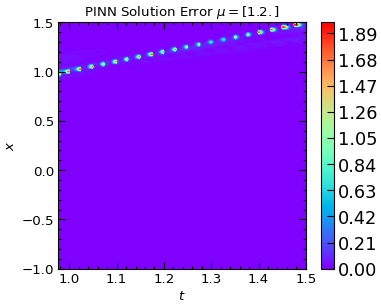

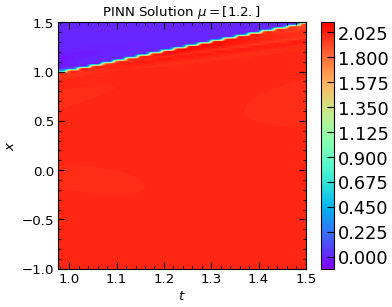

Epoch: 21200 | loss: 0.001781211351044476,rMAE: 0.0054231747053563595, rRMSE:0.040217120200395584,loss_RH:0.00000000,loss_con:4.00023746,loss_R:0.0017216457054018974,loss_IC:5.326400241756346e-06,loss_BC:6.301679604803212e-07
Epoch: 21400 | loss: 0.001755713950842619,rMAE: 0.005412069149315357, rRMSE:0.040245961397886276,loss_RH:0.00000000,loss_con:3.99983120,loss_R:0.001698755077086389,loss_IC:5.09278652316425e-06,loss_BC:6.031019665897475e-07
Epoch: 21600 | loss: 0.0017310242401435971,rMAE: 0.005395365413278341, rRMSE:0.0402870737016201,loss_RH:0.00000000,loss_con:3.99984598,loss_R:0.0016765024047344923,loss_IC:4.872365934716072e-06,loss_BC:5.798187316941039e-07
Epoch: 21800 | loss: 0.0017072019400075078,rMAE: 0.005381860304623842, rRMSE:0.04032320901751518,loss_RH:0.00000000,loss_con:3.99984503,loss_R:0.0016549054998904467,loss_IC:4.662261744670104e-06,loss_BC:5.673775831382954e-07
Epoch: 22000 | loss: 0.0016841369215399027,rMAE: 0.005365030374377966, rRMSE:0.040350329130887985,loss

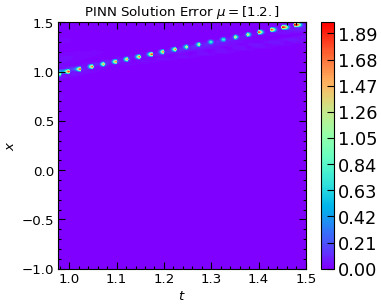

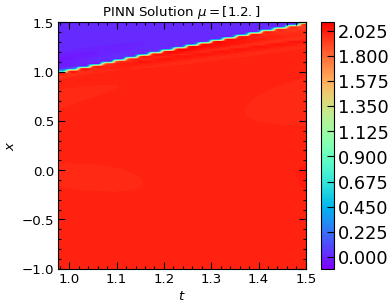

Epoch: 22200 | loss: 0.0017563683213666081,rMAE: 0.005385295953601599, rRMSE:0.04064404219388962,loss_RH:0.00000000,loss_con:3.99978065,loss_R:0.0017037865472957492,loss_IC:4.565190920402529e-06,loss_BC:6.929908522579353e-07
Epoch: 22400 | loss: 0.001657585147768259,rMAE: 0.0054375119507312775, rRMSE:0.041430454701185226,loss_RH:0.00000000,loss_con:3.99993515,loss_R:0.0016091464785858989,loss_IC:4.191661446384387e-06,loss_BC:6.522049602608604e-07
Epoch: 22600 | loss: 0.001632563304156065,rMAE: 0.005425902549177408, rRMSE:0.04143591597676277,loss_RH:0.00000000,loss_con:4.00006104,loss_R:0.0015850005438551307,loss_IC:4.082789473613957e-06,loss_BC:6.734867952218337e-07
Epoch: 22800 | loss: 0.0016090457793325186,rMAE: 0.005414213985204697, rRMSE:0.04143628478050232,loss_RH:0.00000000,loss_con:3.99991798,loss_R:0.001562544726766646,loss_IC:3.963102699344745e-06,loss_BC:6.870034781059076e-07
Epoch: 23000 | loss: 0.001586748519912362,rMAE: 0.005407985299825668, rRMSE:0.04144807159900665,loss_

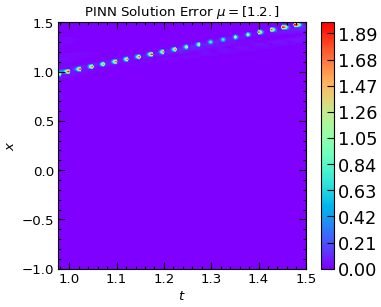

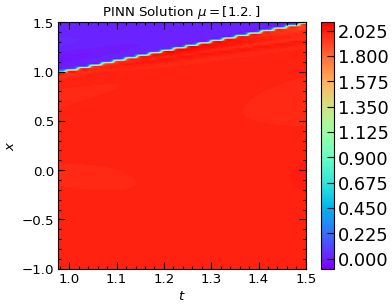

Epoch: 23200 | loss: 0.0015651880530640483,rMAE: 0.005390253383666277, rRMSE:0.041462816298007965,loss_RH:0.00000000,loss_con:3.99982023,loss_R:0.001521023572422564,loss_IC:3.714514832608984e-06,loss_BC:7.01934936842008e-07
Epoch: 23400 | loss: 0.00154442701023072,rMAE: 0.00537417596206069, rRMSE:0.041481953114271164,loss_RH:0.00000000,loss_con:4.00013733,loss_R:0.0015014567179605365,loss_IC:3.5901000501326052e-06,loss_BC:7.069315302032919e-07
Epoch: 23600 | loss: 0.001526829437352717,rMAE: 0.0053972238674759865, rRMSE:0.04149957001209259,loss_RH:0.00000000,loss_con:3.99749565,loss_R:0.0014826797414571047,loss_IC:3.507380824885331e-06,loss_BC:9.075861839846766e-07
Epoch: 23800 | loss: 0.0015045669861137867,rMAE: 0.005359698086977005, rRMSE:0.04152122884988785,loss_RH:0.00000000,loss_con:3.99986172,loss_R:0.001464013010263443,loss_IC:3.339966497151181e-06,loss_BC:7.154268928388774e-07
Epoch: 24000 | loss: 0.0014853536849841475,rMAE: 0.005344376899302006, rRMSE:0.041547950357198715,loss_

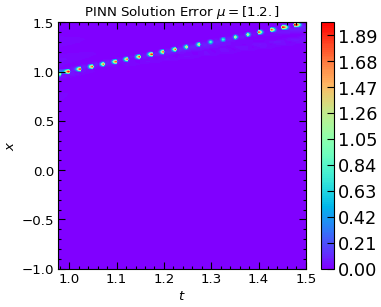

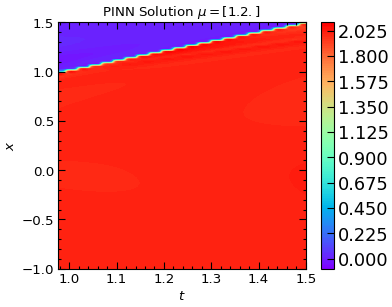

Epoch: 24200 | loss: 0.0014665588969364762,rMAE: 0.005343905184417963, rRMSE:0.04157477244734764,loss_RH:0.00000000,loss_con:3.99984837,loss_R:0.0014283061027526855,loss_IC:3.099154582741903e-06,loss_BC:7.261230621224968e-07
Epoch: 24400 | loss: 0.0014481559628620744,rMAE: 0.0053351568058133125, rRMSE:0.04160599410533905,loss_RH:0.00000000,loss_con:4.00002193,loss_R:0.0014110106276348233,loss_IC:2.9834795896022115e-06,loss_BC:7.310511023206345e-07
Epoch: 24600 | loss: 0.001430176431313157,rMAE: 0.0053292205557227135, rRMSE:0.041638098657131195,loss_RH:0.00000000,loss_con:3.99982548,loss_R:0.0013940926874056458,loss_IC:2.8707920591841685e-06,loss_BC:7.375790573860286e-07
Epoch: 24800 | loss: 0.0014125885209068656,rMAE: 0.0053270249627530575, rRMSE:0.04167388379573822,loss_RH:0.00000000,loss_con:3.99960995,loss_R:0.0013774771941825747,loss_IC:2.76247487818182e-06,loss_BC:7.486564186365285e-07
Epoch: 25000 | loss: 0.0013953126035630703,rMAE: 0.005314873065799475, rRMSE:0.04171907529234886

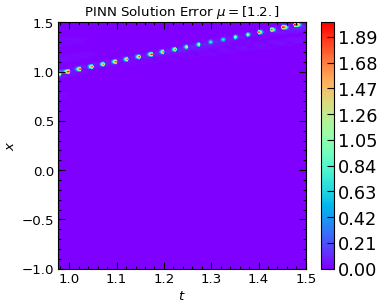

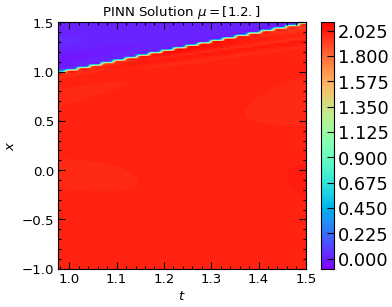

PINN Training Completed

PINN2 Training Time: 0.5488223689264204 Hours


In [14]:
residual_data2 = create_residual_data(Xi, Xf, Ti2, Tf2, Nx_train, Nt_train, Nx_test, Nt_test, dx,dt)
xt_resid2      = residual_data2[0].to(device)
f_hat2         = residual_data2[1].to(device)
xt_test2       = residual_data2[2].to(device)
xt_RHL2      = residual_data2[3].to(device)
xt_RHR2      = residual_data2[4].to(device)
xt_RHt2         = residual_data2[5].to(device)
xt_RHtL2       = residual_data2[6].to(device)

BC_data2 = create_BC_data(Xi, Xf, Ti2, Tf2, BC_pts)
BC_bottom2     = BC_data2[0].to(device)
BC_top2        = BC_data2[1].to(device)

IC_data2 = create_IC_data(nu_pinn_train,Xi, Xf, Ti2, Tf2, IC_pts, IC_simple)
IC_xt2     = IC_data2[0].to(device)
IC_u2      = IC_data2[1].to(device)

Exact_y2 = exact_u(nu_pinn_train,xt_test2)[:,None].to(device)
###   IFNN2 training   ####
pinn2_train_time_1 = time.perf_counter()
PINN2 = NN2(nu_pinn_train,layers_pinn,dt,cut_t).to(device)
    
pinn2_losses = pinn2_train(PINN2, nu_pinn_train,PINN1, xt_resid2, IC_xt2, IC_u2, BC_bottom2, BC_top2, xt_RHL2,xt_RHR2,xt_RHt2,xt_RHtL2, f_hat2,Exact_y2, epochs_pinn2, lr_pinn2, tol_pinn2, xt_test2)
pinn2_train_time_2 = time.perf_counter()
print(f"PINN2 Training Time: {(pinn2_train_time_2-pinn2_train_time_1)/3600} Hours")

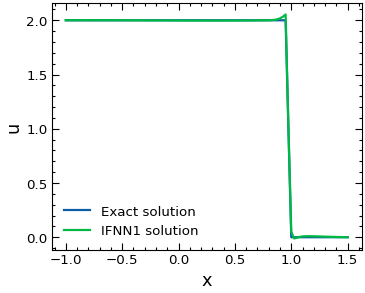

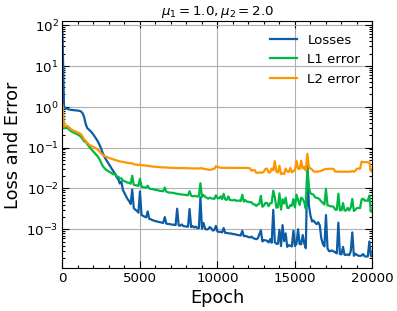

In [15]:
###   Plot1   ###
plt.figure(dpi=80, figsize=(5,4))
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),Exact_y1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label='Exact solution')
plt.plot(xt_test1[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),PINN1(xt_test1)[(Nt_test-1)*Nx_test:Nt_test*Nx_test,0].detach().cpu(),label = 'IFNN1 solution')
plt.xlabel("x",     fontsize=16)
plt.ylabel("u",     fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#20
plt.show()

#Burgers_plot(xt_test1, Exact_y1, Nx_test,Nt_test, title=fr"Step1 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, PINN1(xt_test1),Nx_test,Nt_test, title=fr"IFNN1 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test1, abs(PINN1(xt_test1)-Exact_y1), Nx_test,Nt_test,title=fr"IFNN1 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn1_losses[0], pinn1_losses[1], label="Losses")
plt.plot(pinn1_losses[0], pinn1_losses[2], label="L1 error")
plt.plot(pinn1_losses[0], pinn1_losses[3], label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()
##########################################

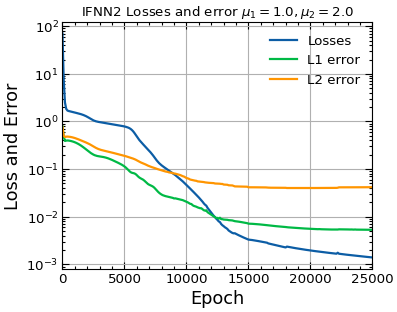

In [16]:
###     Plot2    ###
#Burgers_plot(xt_test2, Exact_y2, Nx_test,Nt_test, title=fr"Step2 Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test2, PINN2(xt_test2),Nx_test,Nt_test, title=fr"IFNN2 Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
#Burgers_plot(xt_test2, abs(PINN2(xt_test2)-Exact_y2), Nx_test,Nt_test,title=fr"IFNN2 Error  $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

plt.figure(dpi=80, figsize=(5,4))    
plt.plot(pinn2_losses[0], pinn2_losses[1], linewidth=2, label="Losses")
plt.plot(pinn2_losses[0], pinn2_losses[2], linewidth=2, label="L1 error")
plt.plot(pinn2_losses[0], pinn2_losses[3], linewidth=2, label="L2 error")
#plt.plot(pinn2_losses[0], pinn2_losses[4], linewidth=2, label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss and Error", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
plt.xlim(0,max(pinn2_losses[0]))
plt.yscale('log')
plt.title(fr"IFNN2 Losses and error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)
plt.show()
###########################################

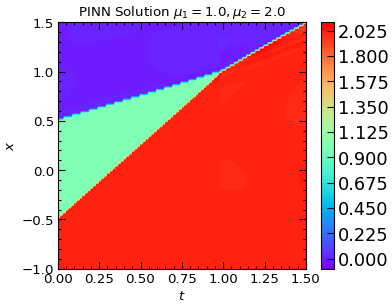

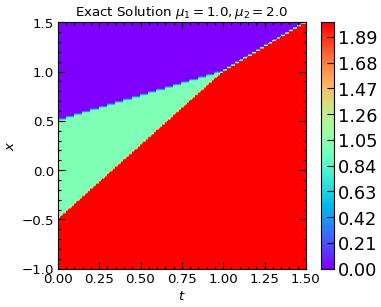

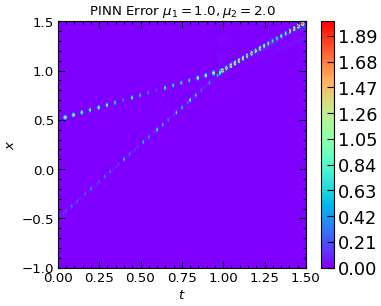

PINN at mu_1=1.0,mu_2=2.0 with the rMAE = 0.004251232836395502 and rRMSE = 0.036631204187870026


In [17]:
###   Plot   ###
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0),Nx_test,2*Nt_test, title=fr"PINN Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((Exact_y1,Exact_y2),0),Nx_test,2*Nt_test, title=fr"Exact Solution $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")
Burgers_plot(torch.cat((xt_test1,xt_test2),0), torch.cat((abs(PINN1(xt_test1)-Exact_y1),abs(PINN2(xt_test2)-Exact_y2)),0),Nx_test,2*Nt_test, title=fr"PINN Error $\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$")

rMAE = max(sum(abs(torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0)))/sum(abs(torch.cat((Exact_y1,Exact_y2),0))))
rRMSE = torch.sqrt(sum((torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)-torch.cat((Exact_y1,Exact_y2),0))**2)/sum((torch.cat((Exact_y1,Exact_y2),0))**2)).item()
print(f"PINN at mu_1={round(nu_pinn_train[0],3)},mu_2={round(nu_pinn_train[1],3)} with the rMAE = {rMAE} and rRMSE = {rRMSE}")

In [18]:
###   Save1   ###
w1 = PINN1.linears[0].weight.detach().cpu()
w2 = PINN1.linears[1].weight.detach().cpu()
w3 = PINN1.linears[2].weight.detach().cpu()
w4 = PINN1.linears[3].weight.detach().cpu()
w5 = PINN1.linears[4].weight.detach().cpu()
w6 = PINN1.linears[5].weight.detach().cpu()

b1 = PINN1.linears[0].bias.detach().cpu()
b2 = PINN1.linears[1].bias.detach().cpu()
b3 = PINN1.linears[2].bias.detach().cpu()
b4 = PINN1.linears[3].bias.detach().cpu()
b5 = PINN1.linears[4].bias.detach().cpu()
b6 = PINN1.linears[5].bias.detach().cpu()

IFNN1=P(layers_pinn, w1, w2, w3, w4,w5,w6, b1, b2, b3, b4,b5,b6).to(device)
#     with open('IFNN1_0109.pkl', 'wb') as f:
#          pickle.dump(IFNN1, f)
#     with open('IFNN2_loss_0109.pkl', 'wb') as f:
#          pickle.dump((pinn2_losses), f)

###   Save2   ###
m1 = PINN2.linears[0].weight.detach().cpu()
m2 = PINN2.linears[1].weight.detach().cpu()
m3 = PINN2.linears[2].weight.detach().cpu()
m4 = PINN2.linears[3].weight.detach().cpu()
m5 = PINN2.linears[4].weight.detach().cpu()
m6 = PINN2.linears[5].weight.detach().cpu()

n1 = PINN2.linears[0].bias.detach().cpu()
n2 = PINN2.linears[1].bias.detach().cpu()
n3 = PINN2.linears[2].bias.detach().cpu()
n4 = PINN2.linears[3].bias.detach().cpu()
n5 = PINN2.linears[4].bias.detach().cpu()
n6 = PINN2.linears[5].bias.detach().cpu()
IFNN2 = P(layers_pinn, m1,m2,m3,m4,m5,m6,n1,n2,n3,n4,n5,n6).to(device)
#     with open('IFNN2_0109.pkl', 'wb') as f:
#          pickle.dump(IFNN2, f)

#     with open('IFNN2_loss_0109.pkl', 'wb') as f:
#          pickle.dump((pinn2_losses), f)

with open('IFNN_shock2_1020_cut.pkl','wb') as f:
    pickle.dump((IFNN1,IFNN2,pinn1_losses,pinn2_losses), f)

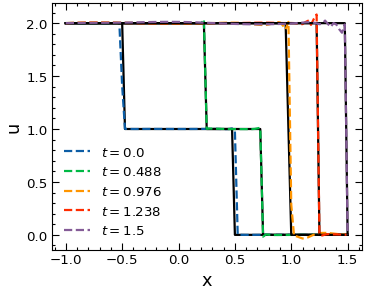

In [19]:
plt.figure(dpi=80, figsize=(5,4))

for ind in range(1, Nt_test,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round((ind-1)*(Tf-Ti)/(Nt_test-1),3)}$")
for ind in range(Nt_test+1, 2*Nt_test+1,100):
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((Exact_y1,Exact_y2),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'k')
    plt.plot(torch.cat((xt_test1,xt_test2),0)[0:Nx_test,0].detach().cpu(),torch.cat((PINN1(xt_test1),PINN2(xt_test2)),0)[(ind-1)*Nx_test:ind*Nx_test,0].detach().cpu(),'--',label=fr"$t={round(Ti2+(ind-1-Nt_test)*(Tf2-Ti2)/(Nt_test-1),3)}$")

plt.xlabel("x",     fontsize=16)
plt.ylabel("u", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

plt.legend(fontsize = 12)#
plt.show()

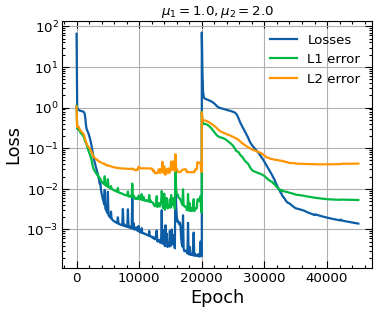

In [20]:
pinn1_losses = torch.tensor(pinn1_losses)
pinn2_losses = torch.tensor(pinn2_losses)
plt.figure(dpi=80, figsize=(5,4))    
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[1],pinn2_losses[1]),0), label="Losses")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[2],pinn2_losses[2]),0), label="L1 error")
plt.plot(torch.cat((pinn1_losses[0],pinn1_losses[0][-1]+pinn2_losses[0]),0), torch.cat((pinn1_losses[3],pinn2_losses[3]),0), label="L2 error")
#plt.plot(pinn1_losses[0], pinn1_losses[4], label="Loss_pde")

plt.xlabel("Epoch",     fontsize=16)
plt.ylabel("Loss", fontsize=16)

plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)
    
plt.grid(True)
#plt.xlim(0,max(pinn1_losses[0]))
plt.yscale('log')
plt.title(fr"$\mu_1={round(nu_pinn_train[0],3)},\mu_2={round(nu_pinn_train[1],3)}$", fontsize=12)
plt.legend(fontsize = 12)#
plt.show()